# Mod 5 Project - Using Machine Learning to Predict Coronavirus

This project uses daily updated coronavirus data from John Hopkins Hospital

## COVID-19 MAP

### HOW MANY COUNTRIES, HOW MANY PEOPLE CONTAGIOUS, HOW MANY DEATH CASES???

## PERCENTAGE OF CONFIRMED CASES/POPULATION, DEATH CASES/CONFIRMED CASES, RECOVERED/CONFIRMED CASES.

### STEP 1: IMPORT ALL NECCESSARY LIBRARIES

In [134]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

sns.set_style('whitegrid')
plt.style.use('ggplot')

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

In [2]:
### from __future__ import print_function
import pandas as pd
import numpy as np
import os
#import pickle
import os.path
from datetime import datetime
import pyarrow
import matplotlib.pyplot as plt
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#set ggplot style
plt.style.use('ggplot')


In [14]:
# Dynamic parameters
data_dir  = './data/' + str(datetime.date(datetime.now()))
agg_file  = 'agg_data_{}.parquet.gzip'.format(datetime.date(datetime.now()))
trend_file  = 'trend_{}.csv'.format(datetime.date(datetime.now()))
report  = 'report_{}.xlsx'.format(datetime.date(datetime.now()))

COUNTRY = 'Uk'


print(trend_file)

# import data
agg_df = pd.read_parquet(os.path.join(data_dir, agg_file))
daily_df = pd.read_csv(os.path.join(data_dir, trend_file))

# daily_df.new_confirmed_cases = daily_df.new_confirmed_cases.abs()

#Create place to save diagrams
image_dir = './images/'
if not os.path.exists(image_dir):
    os.mkdir(image_dir)


trend_2020-03-27.csv


OSError: Passed non-file path: ./data/2020-03-27/agg_data_2020-03-27.parquet.gzip

### STEP 2: LOAD DATA
#### We have 3 data sets: Confirmed cases, Death cases & Recovered cases

In [3]:
# load data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv(url + 'time_series_covid19_recovered_global.csv')

In [4]:
df_population_K = pd.read_csv('population_by_country_2020.csv')
df_population_K.head()

Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0                   China         1439323776         0.39%     5540090   
1                   India         1380004385         0.99%    13586631   
2           United States          331002651         0.59%     1937734   
3               Indonesia          273523615         1.07%     2898047   
4                Pakistan          220892340         2.00%     4327022   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0              153          9388211       -348399.0        1.7       38   
1              464          2973190       -532687.0        2.2       28   
2               36          9147420        954806.0        1.8       38   
3              151          1811570        -98955.0        2.3       30   
4              287           770880       -233379.0        3.6       23   

  Urban Pop % World Share  
0         61%      18.47%  
1         35%      17.70%  
2         83%       4.25%  
3         56%       3.51%  
4         35%       2.83%

In [5]:
df_population_K.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
Country (or dependency)    235 non-null object
Population (2020)          235 non-null int64
Yearly Change              235 non-null object
Net Change                 235 non-null int64
Density (P/Km²)            235 non-null int64
Land Area (Km²)            235 non-null int64
Migrants (net)             201 non-null float64
Fert. Rate                 235 non-null object
Med. Age                   235 non-null object
Urban Pop %                235 non-null object
World Share                235 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 20.3+ KB


In [6]:
df_2020_K = df_population_K.filter(['Country (or dependency)', 'Population (2020)'])
df_2020_K.reset_index(inplace=True)
df_2020_K.drop(['index'], axis=1, inplace=True)
df_2020_K.head()


Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
2           United States          331002651
3               Indonesia          273523615
4                Pakistan          220892340

### STEP 3: INITIAL EXPLORATORY DATA ANALYSIS - EDA:

### A/ INITIAL ANALYSIS - df_confirmed

In [7]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/18/20  3/19/20  3/20/20  3/21/20  \
0        0        0        0  ...       22       22       24       24   
1        0        0        0  ...       59       64       70       76   
2        0        0        0  ...       74       87       90      139   
3        0        0        0  ...       39       53       75       88   
4        0        0        0  ...        0        0        1        2   

   3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0       40       40       74       84       94      110  
1       89      104      123      146      174      186  
2      201      230      264      302      367      409  
3      113      133      164      188      224      267  
4        2        3        3        3        4        4  

[5 rows x 70 columns]

In [8]:
df_confirmed.tail()

Province/State         Country/Region        Lat        Long  \
244                    NaN  Saint Kitts and Nevis  17.357822  -62.782998   
245  Northwest Territories                 Canada  64.825500 -124.845700   
246                  Yukon                 Canada  64.282300 -135.000000   
247                    NaN                 Kosovo  42.602636   20.902977   
248                    NaN                  Burma  21.916200   95.956000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  3/18/20  \
244        0        0        0        0        0        0  ...        0   
245        0        0        0        0        0        0  ...        0   
246        0        0        0        0        0        0  ...        0   
247        0        0        0        0        0        0  ...        0   
248        0        0        0        0        0        0  ...        0   

     3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  \
244        0        0        0        0        0        0        2        2   
245        0        0        0        0        0        0        0        1   
246        0        0        0        0        0        0        0        3   
247        0        0        0        0        0        0        0       71   
248        0        0        0        0        0        0        0        0   

     3/27/20  
244        2  
245        1  
246        3  
247       86  
248        8  

[5 rows x 70 columns]

In [9]:
df_confirmed.describe(include=['object', 'bool'])

Province/State Country/Region
count              76            249
unique             76            176
top             Hubei          China
freq                1             33

In [10]:
df_confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  249.00000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean    22.27243   24.439131    2.228916    2.626506    3.779116    5.759036   
std     24.55691   71.376441   28.193024   28.292843   35.218835   49.012076   
min    -41.45450 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      8.53800  -15.180400    0.000000    0.000000    0.000000    0.000000   
50%     24.00000   21.005900    0.000000    0.000000    0.000000    0.000000   
75%     41.37750   88.092400    0.000000    0.000000    0.000000    0.000000   
max     71.70690  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...       3/18/20  \
count   249.000000   249.000000   249.000000   249.000000  ...    249.000000   
mean      8.506024    11.755020    22.401606    24.763052  ...    862.734940   
std      68.489646    92.276147   226.504645   227.871701  ...   5155.814731   
min       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
25%       0.000000     0.000000     0.000000     0.000000  ...      2.000000   
50%       0.000000     0.000000     0.000000     0.000000  ...     35.000000   
75%       0.000000     0.000000     0.000000     0.000000  ...    176.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  ...  67800.000000   

            3/19/20       3/20/20       3/21/20       3/22/20       3/23/20  \
count    249.000000    249.000000    249.000000    249.000000    249.000000   
mean     973.895582   1092.510040   1222.473896   1353.224900   1519.016064   
std     5455.296330   5819.093819   6260.531854   6711.459637   7336.512742   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      5.000000      8.000000   
50%       42.000000     49.000000     60.000000     75.000000     77.000000   
75%      217.000000    254.000000    305.000000    327.000000    377.000000   
max    67800.000000  67800.000000  67800.000000  67800.000000  67800.000000   

            3/24/20       3/25/20       3/26/20        3/27/20  
count    249.000000    249.000000    249.000000     249.000000  
mean    1678.895582   1878.124498   2126.871486    2382.694779  
std     7969.055203   8814.837594   9959.651172   11154.529524  
min        0.000000      0.000000      0.000000       0.000000  
25%        8.000000     11.000000     13.000000      13.000000  
50%       87.000000     96.000000    109.000000     119.000000  
75%      411.000000    466.000000    520.000000     575.000000  
max    69176.000000  74386.000000  83836.000000  101657.000000  

[8 rows x 68 columns]

In [11]:
# count the null columns
null_columns = df_confirmed.columns[df_confirmed.isnull().any()]
df_confirmed[null_columns].isnull().sum().head()

Province/State    173
dtype: int64

In [12]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [13]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
46             NaN
47             NaN
48             NaN
82             NaN
83             NaN
84             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
94             NaN
95             NaN
96             NaN
97             NaN
98             NaN
99             NaN
100            NaN
101            NaN
102            NaN
103            NaN
104            NaN
105         

In [14]:
len(df_confirmed['Province/State'].unique())

77

In [15]:
print(df_confirmed['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Anhui' 'Beijing'
 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou' 'Hainan'
 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Mayotte' 'New Caledonia'
 'Reunion' 'Saint Barthelemy' 'St Martin' 'Martinique' 'Aruba' 'Curacao'
 'Sint Maarten' 'Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar'
 'Isle of Man' 'Montserrat' 'Diamond Princess' 'Recovered'
 'Northwest Territories' 'Yukon'

In [16]:
len(df_confirmed['Country/Region'].unique())

176

In [17]:
print(df_confirmed['Country/Region'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lebanon' 'L

### B/ INITIAL ANALYSIS - df_deaths

In [18]:
df_deaths.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        1        1        1        1   
2       0       0       0        0        0        1        2        3   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        0        0        0        0        0        0        1   
1        1        1        1        2        2        2        2        2   
2        4        4        4        7        9       11       15       17   
3        0        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0        1        1        2        4        4  
1        4        5        5        6        8  
2       17       19       21       25       26  
3        1        1        1        3        3  
4        0        0        0       

In [19]:
df_deaths.tail()

Province/State         Country/Region        Lat        Long  \
244                    NaN  Saint Kitts and Nevis  17.357822  -62.782998   
245  Northwest Territories                 Canada  64.825500 -124.845700   
246                  Yukon                 Canada  64.282300 -135.000000   
247                    NaN                 Kosovo  42.602636   20.902977   
248                    NaN                  Burma  21.916200   95.956000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   
248        0        0        0        0        0        0        0        0   

     1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  \
244        0        0       0       0       0       0       0       0       0   
245        0        0       0       0       0       0       0       0       0   
246        0        0       0       0       0       0       0       0       0   
247        0        0       0       0       0       0       0       0       0   
248        0        0       0       0       0       0       0       0       0   

     2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
244       0       0        0        0        0        0        0        0   
245       0       0        0        0        0        0        0        0   
246       0       0        0        0        0        0        0        0   
247       0       0        0        0        0        0        0        0   
248       0       0        0        0        0        0        0        0   

     2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   
248        0        0        0        0        0        0        0        0   

     2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  \
244        0        0        0        0        0        0       0       0   
245        0        0        0        0        0        0       0       0   
246        0        0        0        0        0        0       0       0   
247        0        0        0        0        0        0       0       0   
248        0        0        0        0        0        0       0       0   

     3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  \
244       0       0       0       0       0       0       0        0        0   
245       0       0       0       0       0       0       0        0        0   
246       0       0       0       0       0       0       0        0        0   
247       0       0       0       0       0       0       0        0        0   
248       0       0       0       0       0       0       0        0        0   

     3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  \
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   
248        0        0        0        0        0        0        0        0   

     3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
244        0        0        0        0        0        0        0        0  
245        0        0        0        0        0        0        0        

In [20]:
df_deaths.describe(include=['object', 'bool'])

Province/State Country/Region
count              76            249
unique             76            176
top             Hubei          China
freq                1             33

In [21]:
df_deaths.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  249.00000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean    22.27243   24.439131    0.068273    0.072289    0.104418    0.168675   
std     24.55691   71.376441    1.077331    1.078938    1.523056    2.535964   
min    -41.45450 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      8.53800  -15.180400    0.000000    0.000000    0.000000    0.000000   
50%     24.00000   21.005900    0.000000    0.000000    0.000000    0.000000   
75%     41.37750   88.092400    0.000000    0.000000    0.000000    0.000000   
max     71.70690  178.065000   17.000000   17.000000   24.000000   40.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     0.224900    0.329317    0.526104    0.534137    0.686747    0.855422   
std      3.296752    4.817222    7.921510    7.921989   10.266522   12.927652   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     52.000000   76.000000  125.000000  125.000000  162.000000  204.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20      2/6/20  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     1.040161    1.453815    1.710843    1.975904    2.265060    2.546185   
std     15.778916   22.178866   26.234456   30.353286   34.788793   39.161356   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    249.000000  350.000000  414.000000  479.000000  549.000000  618.000000   

          2/7/20      2/8/20      2/9/20     2/10/20     2/11/20     2/12/20  \
count  249.00000  249.000000  249.000000  249.000000   249.00000   249.00000   
mean     2.88755    3.236948    3.638554    4.068273     4.46988     4.48996   
std     44.29378   49.426347   55.192240   61.718855    67.67534    67.67487   
min      0.00000    0.000000    0.000000    0.000000     0.00000     0.00000   
25%      0.00000    0.000000    0.000000    0.000000     0.00000     0.00000   
50%      0.00000    0.000000    0.000000    0.000000     0.00000     0.00000   
75%      0.00000    0.000000    0.000000    0.000000     0.00000     0.00000   
max    699.00000  780.000000  871.000000  974.000000  1068.00000  1068.00000   

           2/13/20      2/14/20      2/15/20      2/16/20      2/17/20  \
count   249.000000   249.000000   249.000000   249.000000   249.000000   
mean      5.506024     6.116466     6.690763     7.108434     7.502008   
std      83.009090    92.324586   101.132722   107.468676   113.362327   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1310.000000  1457.000000  1596.000000  1696.000000  1789.000000   

           2/18/20      2/19/20      2/20/20      2/21/20      2/22/20  \
count   249.000000   249.000000   249.000000   249.000000   249.000000   
mean      8.060241     8.522088     9.024096     9.040161     9.871486   
std     121.727089   128.569551   135.854700   135.853865   148.653254   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   


In [22]:
# count the null columns
null_columns = df_deaths.columns[df_deaths.isnull().any()]
df_deaths[null_columns].isnull().sum().head()

Province/State    173
dtype: int64

In [23]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [24]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
46             NaN
47             NaN
48             NaN
82             NaN
83             NaN
84             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
94             NaN
95             NaN
96             NaN
97             NaN
98             NaN
99             NaN
100            NaN
101            NaN
102            NaN
103            NaN
104            NaN
105         

In [25]:
len(df_deaths['Province/State'].unique())

77

In [26]:
print(df_deaths['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Anhui' 'Beijing'
 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou' 'Hainan'
 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Mayotte' 'New Caledonia'
 'Reunion' 'Saint Barthelemy' 'St Martin' 'Martinique' 'Aruba' 'Curacao'
 'Sint Maarten' 'Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar'
 'Isle of Man' 'Montserrat' 'Diamond Princess' 'Recovered'
 'Northwest Territories' 'Yukon'

In [27]:
len(df_deaths['Country/Region'].unique())

176

In [28]:
print(df_deaths['Country/Region'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lebanon' 'L

### C/ INITIAL ANALYSIS - df_recovered

In [29]:
df_recovered.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0        1        1        2        2        2  
1        2       10       17       17       31  
2       65       24       65       29       29  
3        1        1        1        1        1  
4        0        0        0       

In [30]:
df_recovered.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0        1        1        2        2        2  
1        2       10       17       17       31  
2       65       24       65       29       29  
3        1        1        1        1        1  
4        0        0        0       

In [31]:
df_recovered.tail()

Province/State      Country/Region        Lat        Long  1/22/20  \
230            NaN            Zimbabwe -20.000000   30.000000        0   
231            NaN  West Bank and Gaza  31.952200   35.233200        0   
232            NaN                Laos  19.856270  102.495496        0   
233            NaN              Kosovo  42.602636   20.902977        0   
234            NaN               Burma  21.916200   95.956000        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   
234        0        0        0        0        0        0        0        0   

     1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  \
230        0       0       0       0       0       0       0       0       0   
231        0       0       0       0       0       0       0       0       0   
232        0       0       0       0       0       0       0       0       0   
233        0       0       0       0       0       0       0       0       0   
234        0       0       0       0       0       0       0       0       0   

     2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
230       0        0        0        0        0        0        0        0   
231       0        0        0        0        0        0        0        0   
232       0        0        0        0        0        0        0        0   
233       0        0        0        0        0        0        0        0   
234       0        0        0        0        0        0        0        0   

     2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  \
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   
234        0        0        0        0        0        0        0        0   

     2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
230        0        0        0        0        0       0       0       0   
231        0        0        0        0        0       0       0       0   
232        0        0        0        0        0       0       0       0   
233        0        0        0        0        0       0       0       0   
234        0        0        0        0        0       0       0       0   

     3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  \
230       0       0       0       0       0       0        0        0   
231       0       0       0       0       0       0        0        0   
232       0       0       0       0       0       0        0        0   
233       0       0       0       0       0       0        0        0   
234       0       0       0       0       0       0        0        0   

     3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  \
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   
234        0        0        0        0        0        0        0        0   

     3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
230        0        0        0        0        0        0        0        0  
231       17       17       17       17       17       17       17       17  
232        0        0        0        0        0      

In [32]:
df_recovered.describe(include=['object', 'bool'])

Province/State Country/Region
count              61            235
unique             61            176
top          Victoria          China
freq                1             33

In [33]:
df_recovered.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  235.000000   
mean    20.979595   30.709046    0.119149    0.127660    0.153191    0.165957   
std     24.234171   67.768297    1.826519    1.830616    2.028099    2.096525   
min    -41.454500 -106.346800    0.000000    0.000000    0.000000    0.000000   
25%      7.743250   -5.450350    0.000000    0.000000    0.000000    0.000000   
50%     23.634500   24.603200    0.000000    0.000000    0.000000    0.000000   
75%     40.034550   93.194800    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   28.000000   28.000000   31.000000   32.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  235.000000   
mean     0.221277    0.259574    0.455319    0.536170    0.608511    0.944681   
std      2.749121    2.959243    5.249453    5.774407    5.937705    9.300372   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     42.000000   45.000000   80.000000   88.000000   90.000000  141.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20     2/6/20  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  235.00000   
mean     1.208511    2.008511    2.651064    3.625532    4.782979    6.32766   
std     11.131073   19.437604   25.460325   34.475127   42.022274   54.30390   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
max    168.000000  295.000000  386.000000  522.000000  633.000000  817.00000   

            2/7/20       2/8/20       2/9/20      2/10/20      2/11/20  \
count   235.000000   235.000000   235.000000   235.000000   235.000000   
mean      8.557447    11.131915    13.804255    16.791489    19.927660   
std      74.056746    95.753532   119.324684   147.485633   175.042849   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1115.000000  1439.000000  1795.000000  2222.000000  2639.000000   

           2/12/20      2/13/20      2/14/20      2/15/20      2/16/20  \
count   235.000000   235.000000   235.000000   235.000000   235.000000   
mean     21.914894    26.787234    34.289362    39.978723    46.234043   
std     179.475593   229.889674   315.299859   370.910032   437.303598   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2686.000000  3459.000000  4774.000000  5623.000000  6639.000000   

           2/17/20      2/18/20       2/19/20       2/20/20       2/21/20  \
count   235.000000   235.000000    235.000000    235.000000    235.000000   
mean     53.544681    61.072340     68.600000     77.348936     80.382979   
std     517.263453   599.758761    678.892639    773.778131    780.904438   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.000000     0.000000      

In [34]:
# count the null columns
null_columns = df_recovered.columns[df_recovered.isnull().any()]
df_recovered[null_columns].isnull().sum().head()

Province/State    174
dtype: int64

In [35]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [36]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
73             NaN
74             NaN
75             NaN
76             NaN
77             NaN
78             NaN
79             NaN
80             NaN
81             NaN
82             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
92             NaN
93             NaN
94          

In [37]:
len(df_recovered['Province/State'].unique())

62

In [38]:
print(df_recovered['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands'
 'Greenland' 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique'
 'Mayotte' 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'St Martin'
 'Aruba' 'Curacao' 'Sint Maarten' 'Bermuda' 'Cayman Islands'
 'Channel Islands' 'Gibraltar' 'Isle of Man' 'Montserrat']


In [39]:
len(df_recovered['Country/Region'].unique())

176

In [40]:
print(df_recovered['Country/Region'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Grenada' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Holy See' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan'
 'Kazakhstan' 'Kenya' 'Korea, Sout

In [41]:
covid19_list = list(df_recovered['Country/Region'].unique())
covid19_list

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Diamond Princess',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Grenada',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary'

In [42]:
covid19_population_K = df_2020_K[df_2020_K['Country (or dependency)'].isin(covid19_list)]
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [43]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    163 non-null object
Population (2020)          163 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


### STEP 4: CLEANING DATA, REDUCE UNNECCESSARY & MISSING DATA FEATURES

#### The column 'Province/State' has 143 missing data, and we actually focus on country information not detail to Province/State. We are going reduce the Province/State column and using total cases by country.

In [44]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        1        1        1       1       1       1       1       1       1   
1        0        0        0       0       0       0       0       0       0   
2        1        1        1       1       3       5      12      12      17   
3        0        0        0       0       1       1       1       1       1   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       4       4        5        7        7        7       11   
1       0       0       2       10       12       23       33       38   
2      17      19      20       20       20       24       26       37   
3       1       1       1        1        1        1        1        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0       16       21       22       22       22       24       24       40   
1       42       51       55       59       64       70       76       89   
2       48       54       60       74       87       90      139      201   
3        1        2       39       39       53       75       88      113   
4        0        0        0        0        0        1        2        2   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0       40       74       84       94      110  
1      104      123      146      174      186  
2      230      264      302      367      409  
3      133      164      188      224      267  
4        3        3        3       

In [45]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_confirmed = df_confirmed.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        1        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       4       4   
1       0       0       0       0       0       0       0       0       2   
2       1       3       5      12      12      17      17      19      20   
3       0       1       1       1       1       1       1       1       1   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        5        7        7        7       11       16       21       22   
1       10       12       23       33       38       42       51       55   
2       20       20       24       26       37       48       54       60   
3        1        1        1        1        1        1        2       39   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0       22       22       24       24       40       40       74       84   
1       59       64       70       76       89      104      123      146   
2       74       87       90      139      201      230      264      302   
3       39       53       75       88      113      133      164      188   
4        0        0        1        2        2        3        3        3   

   3/26/20  3/27/20  
0       94      110  
1      174      186  
2      367      409  
3      224      267  
4        4        4

In [46]:
dropped_df_confirmed.describe(include=['object', 'bool'])

Country/Region
count             249
unique            176
top             China
freq               33

In [47]:
dropped_df_confirmed_total = dropped_df_confirmed.groupby(['Country/Region']).sum()
dropped_df_confirmed_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        1        1   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        1   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           1        1        1        1       1       1       1   
Albania               0        0        0        0       0       0       0   
Algeria               1        1        1        1       1       3       5   
Andorra               0        0        0        0       0       1       1   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          1       1       1       1       4       4        5   
Albania              0       0       0       0       0       2       10   
Algeria             12      12      17      17      19      20       20   
Andorra              1       1       1       1       1       1        1   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [48]:
dropped_df_confirmed_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        2        2        2        2        2   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                           
Venezuela                 0        0        0        0       0       0   
Vietnam                   2        2        2        2       6       6   
West Bank and Gaza        0        0        0        0       0       0   
Zambia                    0        0        0        0       0       0   
Zimbabwe                  0        0        0        0       0       0   

                    2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                               
Venezuela                0       0       0       0       0       0       0   
Vietnam                  8       8       8      10      10      13      13   
West Bank and Gaza       0       0       0       0       0       0       0   
Zambia                   0       0       0       0       0       0       0   
Zimbabwe                 0       0       0       0       0       0       0   

                    2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  14       15       15       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  16       16       16       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  16       16       16       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
Country/Region                                                                 
Venezuela                 0        0       0       0       0       0       0   
Vietnam                  16       16      16      16      16      16      16   
West Bank and Gaza        0        0       0       0       0       0       4   
Zambia                    0        0       0       0       0       0       0   
Zimbabwe                  0        0       0       0       0       0       0   

                    3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
Country/Region                                                                  
Venezuela                0       0       0       0        0        0        0   
Vietnam           

In [49]:
dropped_df_confirmed_total.describe()


1/22/20     1/23/20     1/24/20      1/25/20      1/26/20  \
count  176.000000  176.000000  176.000000   176.000000   176.000000   
mean     3.153409    3.715909    5.346591     8.147727    12.034091   
std     41.304781   48.464408   69.341056   105.971806   156.393821   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    0.000000     0.000000     0.000000   
50%      0.000000    0.000000    0.000000     0.000000     0.000000   
75%      0.000000    0.000000    0.000000     0.000000     0.000000   
max    548.000000  643.000000  920.000000  1406.000000  2075.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   176.000000   176.000000   176.000000   176.000000   176.000000   
mean     16.630682    31.693182    35.034091    46.784091    56.403409   
std     216.843340   415.229915   458.794083   613.614191   738.804294   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2877.000000  5509.000000  6087.000000  8141.000000  9802.000000   

             2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count    176.000000    176.000000    176.000000    176.000000    176.000000   
mean      68.397727     95.380682    112.960227    135.750000    157.017045   
std      896.259625   1253.469848   1486.081999   1786.906791   2068.287862   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    11891.000000  16630.000000  19716.000000  23707.000000  27440.000000   

             2/6/20        2/7/20        2/8/20        2/9/20       2/10/20  \
count    176.000000    176.000000    176.000000    176.000000    176.000000   
mean     174.965909    195.403409    210.909091    228.125000    242.965909   
std     2305.496748   2571.024921   2774.836088   3002.094129   3192.398124   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    30587.000000  34110.000000  36814.000000  39829.000000  42354.000000   

            2/11/20       2/12/20       2/13/20       2/14/20       2/15/20  \
count    176.000000    176.000000    176.000000    176.000000    176.000000   
mean     254.556818    256.937500    343.000000    380.028409    392.215909   
std     3345.561803   3373.668411   4514.575376   5001.726924   5156.608038   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    44386.000000  44759.000000  59895.000000  66358.000000  68413.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    176.000000    176.000000    176.000000    176.000000    176.000000   
mean     404.681818    416.238636    426.909091    429.767045    432.937500   
std     5314.884450   5459.676787   5593.622160   5624.381762   5658.874034   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.0

In [50]:
dropped_df_confirmed.describe()

1/22/20     1/23/20     1/24/20     1/25/20      1/26/20  \
count  249.000000  249.000000  249.000000  249.000000   249.000000   
mean     2.228916    2.626506    3.779116    5.759036     8.506024   
std     28.193024   28.292843   35.218835   49.012076    68.489646   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    444.000000  444.000000  549.000000  761.000000  1058.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   249.000000   249.000000   249.000000   249.000000   249.000000   
mean     11.755020    22.401606    24.763052    33.068273    39.867470   
std      92.276147   226.504645   227.871701   314.029418   372.304574   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1423.000000  3554.000000  3554.000000  4903.000000  5806.000000   

            2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count   249.000000    249.000000    249.000000    249.000000    249.000000   
mean     48.345382     67.417671     79.843373     95.951807    110.983936   
std     458.147349    712.055556    860.793447   1060.907910   1250.217236   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.000000      0.000000      0.000000      0.000000   
max    7153.000000  11177.000000  13522.000000  16678.000000  19665.000000   

             2/6/20        2/7/20        2/8/20        2/9/20      2/10/20  \
count    249.000000    249.000000    249.000000    249.000000    249.00000   
mean     123.670683    138.116466    149.076305    161.244980    171.73494   
std     1405.419193   1585.447479   1721.569421   1881.841118   2014.64188   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%        0.000000      0.000000      0.000000      0.000000      0.00000   
50%        0.000000      0.000000      0.000000      0.000000      0.00000   
75%        0.000000      1.000000      1.000000      1.000000      1.00000   
max    22112.000000  24953.000000  27100.000000  29631.000000  31728.00000   

            2/11/20       2/12/20       2/13/20       2/14/20       2/15/20  \
count    249.000000    249.000000    249.000000    249.000000    249.000000   
mean     179.927711    181.610442    242.441767    268.614458    277.228916   
std     2118.412688   2118.754729   3057.125220   3449.544950   3566.283617   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max    33366.000000  33366.000000  48206.000000  54406.000000  56249.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    249.000000    249.000000    249.000000    249.000000    249.000000   
mean     286.040161    294.208835    301.751004    303.771084    306.012048   
std     3688.695239   3803.114257   3910.316507   3932.441557   3958.448258   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.

In [51]:
#dropped_df_confirmed_total.describe(include=['object', 'bool'])

In [52]:
dropped_df_confirmed_total["current_cases"] = dropped_df_confirmed_total.iloc[:, -1]
dropped_df_confirmed_total = dropped_df_confirmed_total[ ['current_cases'] + [ col for col in dropped_df_confirmed_total.columns if col != 'current_cases' ] ]

In [53]:
sorted_df_confirmed=dropped_df_confirmed_total.drop(['current_cases'], axis=1)
sorted_df_confirmed

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        4   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas                                 0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Belize                                  0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Burma                                   0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        1   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                 548      643      920     1406     2075   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Diamond Princess                        0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0      

In [54]:
dropped_df_confirmed_total.sort_values(by='current_cases', ascending=False, inplace = True)

In [55]:
top30_confirmed = dropped_df_confirmed_total.iloc[0:30,:]
top30_confirmed

current_cases  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                               
US                     101657        1        1        2        2        5   
Italy                   86498        0        0        0        0        0   
China                   81897      548      643      920     1406     2075   
Spain                   65719        0        0        0        0        0   
Germany                 50871        0        0        0        0        0   
France                  33402        0        0        2        3        3   
Iran                    32332        0        0        0        0        0   
United Kingdom          14745        0        0        0        0        0   
Switzerland             12928        0        0        0        0        0   
Korea, South             9332        1        1        2        2        3   
Netherlands              8647        0        0        0        0        0   
Austria                  7657        0        0        0        0        0   
Belgium                  7284        0        0        0        0        0   
Turkey                   5698        0        0        0        0        0   
Canada                   4682        0        0        0        0        1   
Portugal                 4268        0        0        0        0        0   
Norway                   3755        0        0        0        0        0   
Brazil                   3417        0        0        0        0        0   
Australia                3143        0        0        0        0        4   
Sweden                   3069        0        0        0        0        0   
Israel                   3035        0        0        0        0        0   
Czechia                  2279        0        0        0        0        0   
Denmark                  2200        0        0        0        0        0   
Malaysia                 2161        0        0        0        3        4   
Ireland                  2121        0        0        0        0        0   
Chile                    1610        0        0        0        0        0   
Luxembourg               1605        0        0        0        0        0   
Ecuador                  1595        0        0        0        0        0   
Japan                    1468        2        2        2        2        4   
Poland                   1389        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
US                    5        5        5        5        7       8       8   
Italy                 0        0        0        0        2       2       2   
China              2877     5509     6087     8141     9802   11891   16630   
Spain                 0        0        0        0        0       1       1   
Germany               1        4        4        4        5       8      10   
France                3        4        5        5        5       6       6   
Iran                  0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        2       2       2   
Switzerland           0        0        0        0        0       0       0   
Korea, South          4        4        4        4       11      12      15   
Netherlands           0        0        0        0        0       0       0   
Austria               0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Turkey                0        0        0        0        0       0       0   
Canada                1        2        2        2        4       4       4   
Portugal              0        0        0        0        0       0       0   
Norway                0        0        0        0        0       0       0   
Brazil            

In [56]:
top30_confirmed.reset_index(inplace = True)

In [57]:
top_confirmed_list = top30_confirmed['Country/Region']
top_confirmed_list

0                 US
1              Italy
2              China
3              Spain
4            Germany
5             France
6               Iran
7     United Kingdom
8        Switzerland
9       Korea, South
10       Netherlands
11           Austria
12           Belgium
13            Turkey
14            Canada
15          Portugal
16            Norway
17            Brazil
18         Australia
19            Sweden
20            Israel
21           Czechia
22           Denmark
23          Malaysia
24           Ireland
25             Chile
26        Luxembourg
27           Ecuador
28             Japan
29            Poland
Name: Country/Region, dtype: object

In [58]:
df_deaths.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        1        1        1        1   
2       0       0       0        0        0        1        2        3   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        0        0        0        0        0        0        1   
1        1        1        1        2        2        2        2        2   
2        4        4        4        7        9       11       15       17   
3        0        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0        1        1        2        4        4  
1        4        5        5        6        8  
2       17       19       21       25       26  
3        1        1        1        3        3  
4        0        0        0       

In [59]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_deaths = df_deaths.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_deaths.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        0        0        0        0        0        0        0        0   
1        0        1        1        1        1        1        1        1   
2        0        0        1        2        3        4        4        4   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0        0        0        0        0        1        1        1        2   
1        2        2        2        2        2        4        5        5   
2        7        9       11       15       17       17       19       21   
3        0        0        0        0        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/26/20  3/27/20  
0        4        4  
1        6        8  
2       25       26  
3        3        3  
4        0        0

In [60]:
dropped_df_deaths.describe(include=['object', 'bool'])

Country/Region
count             249
unique            176
top             China
freq               33

In [61]:
dropped_df_deaths_total = dropped_df_deaths.groupby(['Country/Region']).sum()
dropped_df_deaths_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [62]:
dropped_df_deaths_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        0        0        0        0        0   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                           
Venezuela                 0        0        0        0       0       0   
Vietnam                   0        0        0        0       0       0   
West Bank and Gaza        0        0        0        0       0       0   
Zambia                    0        0        0        0       0       0   
Zimbabwe                  0        0        0        0       0       0   

                    2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                               
Venezuela                0       0       0       0       0       0       0   
Vietnam                  0       0       0       0       0       0       0   
West Bank and Gaza       0       0       0       0       0       0       0   
Zambia                   0       0       0       0       0       0       0   
Zimbabwe                 0       0       0       0       0       0       0   

                    2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        0        0        0        0        0   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        0        0        0        0        0   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        0        0        0        0        0   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
Country/Region                                                                 
Venezuela                 0        0       0       0       0       0       0   
Vietnam                   0        0       0       0       0       0       0   
West Bank and Gaza        0        0       0       0       0       0       0   
Zambia                    0        0       0       0       0       0       0   
Zimbabwe                  0        0       0       0       0       0       0   

                    3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
Country/Region                                                                  
Venezuela                0       0       0       0        0        0        0   
Vietnam           

In [63]:
dropped_df_deaths_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     0.096591    0.102273    0.147727    0.238636    0.318182    0.465909   
std      1.281423    1.356801    1.959824    3.165869    4.221159    6.180983   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   18.000000   26.000000   42.000000   56.000000   82.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     0.744318    0.755682    0.971591    1.210227    1.471591    2.056818   
std      9.874497   10.025252   12.889610   16.055479   19.522860   27.211073   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    131.000000  133.000000  171.000000  213.000000  259.000000  361.000000   

           2/3/20      2/4/20      2/5/20      2/6/20      2/7/20      2/8/20  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     2.420455    2.795455    3.204545    3.602273    4.085227    4.579545   
std     32.035238   37.010164   42.437358   47.713799   54.120908   60.678774   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    425.000000  491.000000  563.000000  633.000000  718.000000  805.000000   

           2/9/20      2/10/20      2/11/20      2/12/20      2/13/20  \
count  176.000000   176.000000   176.000000   176.000000   176.000000   
mean     5.147727     5.755682     6.323864     6.352273     7.789773   
std     68.216553    76.281977    83.819757    84.196646   103.191451   
min      0.000000     0.000000     0.000000     0.000000     0.000000   
25%      0.000000     0.000000     0.000000     0.000000     0.000000   
50%      0.000000     0.000000     0.000000     0.000000     0.000000   
75%      0.000000     0.000000     0.000000     0.000000     0.000000   
max    905.000000  1012.000000  1112.000000  1117.000000  1369.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   176.000000   176.000000   176.000000   176.000000   176.000000   
mean      8.653409     9.465909    10.056818    10.613636    11.403409   
std     114.648877   125.352117   133.115620   140.502643   150.980157   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1521.000000  1663.000000  1766.000000  1864.000000  2003.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   176.000000   176.000000   176.000000   176.000000   176.000000   
mean     12.056818    12.767045    12.789773    13.965909    14.028409   
std     159.497057   168.691933   168.690473   184.142209   184.290312   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.

In [64]:
dropped_df_deaths.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     0.068273    0.072289    0.104418    0.168675    0.224900    0.329317   
std      1.077331    1.078938    1.523056    2.535964    3.296752    4.817222   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   17.000000   24.000000   40.000000   52.000000   76.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     0.526104    0.534137    0.686747    0.855422    1.040161    1.453815   
std      7.921510    7.921989   10.266522   12.927652   15.778916   22.178866   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    125.000000  125.000000  162.000000  204.000000  249.000000  350.000000   

           2/3/20      2/4/20      2/5/20      2/6/20     2/7/20      2/8/20  \
count  249.000000  249.000000  249.000000  249.000000  249.00000  249.000000   
mean     1.710843    1.975904    2.265060    2.546185    2.88755    3.236948   
std     26.234456   30.353286   34.788793   39.161356   44.29378   49.426347   
min      0.000000    0.000000    0.000000    0.000000    0.00000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.00000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.00000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.00000    0.000000   
max    414.000000  479.000000  549.000000  618.000000  699.00000  780.000000   

           2/9/20     2/10/20     2/11/20     2/12/20      2/13/20  \
count  249.000000  249.000000   249.00000   249.00000   249.000000   
mean     3.638554    4.068273     4.46988     4.48996     5.506024   
std     55.192240   61.718855    67.67534    67.67487    83.009090   
min      0.000000    0.000000     0.00000     0.00000     0.000000   
25%      0.000000    0.000000     0.00000     0.00000     0.000000   
50%      0.000000    0.000000     0.00000     0.00000     0.000000   
75%      0.000000    0.000000     0.00000     0.00000     0.000000   
max    871.000000  974.000000  1068.00000  1068.00000  1310.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   249.000000   249.000000   249.000000   249.000000   249.000000   
mean      6.116466     6.690763     7.108434     7.502008     8.060241   
std      92.324586   101.132722   107.468676   113.362327   121.727089   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1457.000000  1596.000000  1696.000000  1789.000000  1921.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   249.000000   249.000000   249.000000   249.000000   249.000000   
mean      8.522088     9.024096     9.040161     9.871486     9.915663   
std     128.569551   135.854700   135.853865   148.653254   148.651672   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.0

In [65]:
dropped_df_deaths_total["current_deaths"] = dropped_df_deaths_total.iloc[:, -1]
dropped_df_deaths_total = dropped_df_deaths_total[ ['current_deaths'] + [ col for col in dropped_df_deaths_total.columns if col != 'current_deaths' ] ]

In [66]:
sorted_df_deaths=dropped_df_deaths_total.drop(['current_deaths'], axis=1)
sorted_df_deaths

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas                                 0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Belize                                  0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Burma                                   0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  17       18       26       42       56   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Diamond Princess                        0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0      

In [67]:
dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

In [68]:
top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
top30_deaths

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                     9134        0        0        0        0        0   
Spain                     5138        0        0        0        0        0   
China                     3296       17       18       26       42       56   
Iran                      2378        0        0        0        0        0   
France                    1997        0        0        0        0        0   
US                        1581        0        0        0        0        0   
United Kingdom             761        0        0        0        0        0   
Netherlands                547        0        0        0        0        0   
Germany                    342        0        0        0        0        0   
Belgium                    289        0        0        0        0        0   
Switzerland                231        0        0        0        0        0   
Korea, South               139        0        0        0        0        0   
Sweden                     105        0        0        0        0        0   
Brazil                      92        0        0        0        0        0   
Turkey                      92        0        0        0        0        0   
Indonesia                   87        0        0        0        0        0   
Portugal                    76        0        0        0        0        0   
Austria                     58        0        0        0        0        0   
Canada                      54        0        0        0        0        0   
Philippines                 54        0        0        0        0        0   
Denmark                     52        0        0        0        0        0   
Japan                       49        0        0        0        0        0   
Iraq                        40        0        0        0        0        0   
Ecuador                     36        0        0        0        0        0   
Egypt                       30        0        0        0        0        0   
Greece                      28        0        0        0        0        0   
Malaysia                    26        0        0        0        0        0   
Algeria                     26        0        0        0        0        0   
Romania                     26        0        0        0        0        0   
Morocco                     23        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
Spain                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   
US                    0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        0       0       0   
Netherlands           0        0        0        0        0       0       0   
Germany               0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Switzerland           0        0        0        0        0       0       0   
Korea, South          0        0        0        0        0       0       0   
Sweden                0        0        0        0        0       0       0   
Brazil                0        0        0        0        0       0       0   
Turkey                0        0        0        0        0       0       0   
Indonesia             0        0        0        0        0       0       0   
Portugal              0        0        0        0        0      

In [69]:
top30_deaths.reset_index(inplace = True)

In [70]:
top_deaths_list = top30_deaths['Country/Region']
top_deaths_list

0              Italy
1              Spain
2              China
3               Iran
4             France
5                 US
6     United Kingdom
7        Netherlands
8            Germany
9            Belgium
10       Switzerland
11      Korea, South
12            Sweden
13            Brazil
14            Turkey
15         Indonesia
16          Portugal
17           Austria
18            Canada
19       Philippines
20           Denmark
21             Japan
22              Iraq
23           Ecuador
24             Egypt
25            Greece
26          Malaysia
27           Algeria
28           Romania
29           Morocco
Name: Country/Region, dtype: object

In [ ]:
# df9_population = df_2020_K[df_2020_K['Country (or dependency)'].isin(top_deaths_list)]
# df9_population.head()

In [ ]:
# dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

# top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
# top30_deaths

# top30_deaths.reset_index(inplace = True)

# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_deaths', data=top30_deaths,
#                 kind='bar', palette='cool', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

In [71]:
dropped_df_deaths_total.head()

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                     9134        0        0        0        0        0   
Spain                     5138        0        0        0        0        0   
China                     3296       17       18       26       42       56   
Iran                      2378        0        0        0        0        0   
France                    1997        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
Spain                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   

                2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                           
Italy                0       0       0       0       0       0       0   
Spain                0       0       0       0       0       0       0   
China              425     491     563     633     718     805     905   
Iran                 0       0       0       0       0       0       0   
France               0       0       0       0       0       0       0   

                2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
Country/Region                                                                  
Italy                 0        0        0        0        0        0        0   
Spain                 0        0        0        0        0        0        0   
China              1012     1112     1117     1369     1521     1663     1766   
Iran                  0        0        0        0        0        0        0   
France                0        0        0        0        0        1        1   

                2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
Country/Region                                                                  
Italy                 0        0        0        0        1        2        3   
Spain                 0        0        0        0        0        0        0   
China              1864     2003     2116     2238     2238     2443     2445   
Iran                  0        0        2        2        4        5        8   
France                1        1        1        1        1        1        1   

                2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  \
Country/Region                                                                 
Italy                 7       10       12       17       21       29      34   
Spain                 0        0        0        0        0        0       0   
China              2595     2665     2717     2746     2790     2837    2872   
Iran                 12       16       19       26       34       43      54   
France                1        1        2        2        2        2       2   

                3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  \
Country/Region                                                           
Italy               52      79     107     148     197     233     366   
Spain                0       1       2       3       5      10      17   
China             2914    2947    2983    3015    3044    3072    3100   
Iran                66      77      92     107     124     145     194   
France               3       4       4       6       9      11      19   

                3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  \
Country/Region                                                                 
Italy        

In [72]:
df_recovered.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  
0        1        1        2        2        2  
1        2       10       17       17       31  
2       65       24       65       29       29  
3        1        1        1        1        1  
4        0        0        0       

In [73]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_recovered = df_recovered.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_recovered.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        0        0        0        0        0        0        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        8        8       12       12       12       12   
3        0        0        1        0        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0        1        1        1        1        1        1        1        2   
1        0        0        0        2        2        2       10       17   
2       12       32       32       32       65       65       24       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/26/20  3/27/20  
0        2        2  
1       17       31  
2       29       29  
3        1        1  
4        0        0

In [74]:
dropped_df_recovered_total = dropped_df_recovered.groupby(['Country/Region']).sum()
dropped_df_recovered_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [75]:
dropped_df_recovered_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        0        0        0        0        0   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                           
Venezuela                 0        0        0        0       0       0   
Vietnam                   0        0        0        0       1       1   
West Bank and Gaza        0        0        0        0       0       0   
Zambia                    0        0        0        0       0       0   
Zimbabwe                  0        0        0        0       0       0   

                    2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                               
Venezuela                0       0       0       0       0       0       0   
Vietnam                  1       1       1       1       1       1       1   
West Bank and Gaza       0       0       0       0       0       0       0   
Zambia                   0       0       0       0       0       0       0   
Zimbabwe                 0       0       0       0       0       0       0   

                    2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   1        6        6        7        7        7   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   7        7        7        7        7       14   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  14       14       14       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
Country/Region                                                                 
Venezuela                 0        0       0       0       0       0       0   
Vietnam                  16       16      16      16      16      16      16   
West Bank and Gaza        0        0       0       0       0       0       0   
Zambia                    0        0       0       0       0       0       0   
Zimbabwe                  0        0       0       0       0       0       0   

                    3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
Country/Region                                                                  
Venezuela                0       0       0       0        0        0        0   
Vietnam           

In [76]:
dropped_df_recovered_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     0.159091    0.170455    0.204545    0.221591    0.295455    0.346591   
std      2.110579    2.261335    2.713602    2.939736    3.696049    4.373856   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   30.000000   36.000000   39.000000   49.000000   58.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000   
mean     0.607955    0.715909    0.812500    1.261364    1.613636    2.681818   
std      7.620255    9.050902   10.180882   16.132660   20.729238   34.898562   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    101.000000  120.000000  135.000000  214.000000  275.000000  463.000000   

           2/3/20      2/4/20       2/5/20       2/6/20       2/7/20  \
count  176.000000  176.000000   176.000000   176.000000   176.000000   
mean     3.539773    4.840909     6.386364     8.448864    11.426136   
std     46.280000   63.541012    84.043449   111.329563   150.675755   
min      0.000000    0.000000     0.000000     0.000000     0.000000   
25%      0.000000    0.000000     0.000000     0.000000     0.000000   
50%      0.000000    0.000000     0.000000     0.000000     0.000000   
75%      0.000000    0.000000     0.000000     0.000000     0.000000   
max    614.000000  843.000000  1115.000000  1477.000000  1999.000000   

            2/8/20       2/9/20      2/10/20      2/11/20      2/12/20  \
count   176.000000   176.000000   176.000000   176.000000   176.000000   
mean     14.863636    18.431818    22.420455    26.607955    29.261364   
std     195.673879   242.631987   295.319671   349.434007   383.044630   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2596.000000  3219.000000  3918.000000  4636.000000  5082.000000   

           2/13/20      2/14/20      2/15/20       2/16/20       2/17/20  \
count   176.000000   176.000000   176.000000    176.000000    176.000000   
mean     35.767045    45.784091    53.380682     61.732955     71.494318   
std     468.594149   601.257329   700.824826    810.644669    939.310410   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000     0.000000     0.000000      0.000000      0.000000   
50%       0.000000     0.000000     0.000000      0.000000      0.000000   
75%       0.000000     0.000000     0.000000      0.000000      0.000000   
max    6217.000000  7977.000000  9298.000000  10755.000000  12462.000000   

            2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count    176.000000    176.000000    176.000000    176.000000    176.000000   
mean      81.545455     91.596591    103.278409    107.329545    130.034091   
std     1070.759596   1203.118131   1357.791310   1409.793206   1710.926125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000

In [77]:
dropped_df_recovered.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  235.000000   
mean     0.119149    0.127660    0.153191    0.165957    0.221277    0.259574   
std      1.826519    1.830616    2.028099    2.096525    2.749121    2.959243   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   28.000000   31.000000   32.000000   42.000000   45.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  235.000000  235.000000  235.000000  235.000000  235.000000  235.000000   
mean     0.455319    0.536170    0.608511    0.944681    1.208511    2.008511   
std      5.249453    5.774407    5.937705    9.300372   11.131073   19.437604   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     80.000000   88.000000   90.000000  141.000000  168.000000  295.000000   

           2/3/20      2/4/20      2/5/20     2/6/20       2/7/20  \
count  235.000000  235.000000  235.000000  235.00000   235.000000   
mean     2.651064    3.625532    4.782979    6.32766     8.557447   
std     25.460325   34.475127   42.022274   54.30390    74.056746   
min      0.000000    0.000000    0.000000    0.00000     0.000000   
25%      0.000000    0.000000    0.000000    0.00000     0.000000   
50%      0.000000    0.000000    0.000000    0.00000     0.000000   
75%      0.000000    0.000000    0.000000    0.00000     0.000000   
max    386.000000  522.000000  633.000000  817.00000  1115.000000   

            2/8/20       2/9/20      2/10/20      2/11/20      2/12/20  \
count   235.000000   235.000000   235.000000   235.000000   235.000000   
mean     11.131915    13.804255    16.791489    19.927660    21.914894   
std      95.753532   119.324684   147.485633   175.042849   179.475593   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1439.000000  1795.000000  2222.000000  2639.000000  2686.000000   

           2/13/20      2/14/20      2/15/20      2/16/20      2/17/20  \
count   235.000000   235.000000   235.000000   235.000000   235.000000   
mean     26.787234    34.289362    39.978723    46.234043    53.544681   
std     229.889674   315.299859   370.910032   437.303598   517.263453   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    3459.000000  4774.000000  5623.000000  6639.000000  7862.000000   

           2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count   235.000000    235.000000    235.000000    235.000000    235.000000   
mean     61.072340     68.600000     77.348936     80.382979     97.387234   
std     599.758761    678.892639    773.778131    780.904438   1003.026036   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.500000      0.500000  

In [78]:
dropped_df_recovered_total["current_recovered"] = dropped_df_recovered_total.iloc[:, -1]
dropped_df_recovered_total = dropped_df_recovered_total[ ['current_recovered'] + [ col for col in dropped_df_recovered_total.columns if col != 'current_recovered' ] ]

In [79]:
sorted_df_recovered=dropped_df_recovered_total.drop(['current_recovered'], axis=1)
sorted_df_recovered

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas                                 0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Belize                                  0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Burma                                   0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  28       30       36       39       49   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Diamond Princess                        0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0      

In [80]:
dropped_df_recovered_total.sort_values(by='current_recovered', ascending=False, inplace = True)

In [81]:
top30_recovered = dropped_df_recovered_total.iloc[0:30,:]
top30_recovered

current_recovered  1/22/20  1/23/20  1/24/20  1/25/20  \
Country/Region                                                            
China                         74720       28       30       36       39   
Iran                          11133        0        0        0        0   
Italy                         10950        0        0        0        0   
Spain                          9357        0        0        0        0   
Germany                        6658        0        0        0        0   
France                         5707        0        0        0        0   
Korea, South                   4528        0        0        0        0   
Switzerland                    1530        0        0        0        0   
US                              869        0        0        0        0   
Belgium                         858        0        0        0        0   
Diamond Princess                597        0        0        0        0   
Japan                           372        0        0        0        0   
Malaysia                        259        0        0        0        0   
Canada                          256        0        0        0        0   
Bahrain                         227        0        0        0        0   
Austria                         225        0        0        0        0   
Australia                       194        0        0        0        0   
Singapore                       183        0        0        0        0   
United Kingdom                  151        0        0        0        0   
Iraq                            122        0        0        0        0   
Egypt                           116        0        0        0        0   
Romania                         115        0        0        0        0   
Thailand                         97        0        0        0        0   
Iceland                          97        0        0        0        0   
Israel                           79        0        0        0        0   
India                            73        0        0        0        0   
Argentina                        72        0        0        0        0   
Denmark                          57        0        0        0        0   
Kuwait                           57        0        0        0        0   
Greece                           52        0        0        0        0   

                  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
Country/Region                                                           
China                  49       58      101      120      135      214   
Iran                    0        0        0        0        0        0   
Italy                   0        0        0        0        0        0   
Spain                   0        0        0        0        0        0   
Germany                 0        0        0        0        0        0   
France                  0        0        0        0        0        0   
Korea, South            0        0        0        0        0        0   
Switzerland             0        0        0        0        0        0   
US                      0        0        0        0        0        0   
Belgium                 0        0        0        0        0        0   
Diamond Princess        0        0        0        0        0        0   
Japan                   1        1        1        1        1        1   
Malaysia                0        0        0        0        0        0   
Canada                  0        0        0        0        0        0   
Bahrain                 0        0        0        0        0        0   
Austria                 0        0        0        0        0        0   
Australia               0        0        0        0        2        2   
Singapore               0        0        0        0        0        0   
United Kingdom          0        0        0        0        0        0   
Iraq                    0        0        0        0        0  

In [82]:
top30_recovered.reset_index(inplace = True)

In [83]:
top_recovered_list = top30_recovered['Country/Region']
top_recovered_list

0                China
1                 Iran
2                Italy
3                Spain
4              Germany
5               France
6         Korea, South
7          Switzerland
8                   US
9              Belgium
10    Diamond Princess
11               Japan
12            Malaysia
13              Canada
14             Bahrain
15             Austria
16           Australia
17           Singapore
18      United Kingdom
19                Iraq
20               Egypt
21             Romania
22            Thailand
23             Iceland
24              Israel
25               India
26           Argentina
27             Denmark
28              Kuwait
29              Greece
Name: Country/Region, dtype: object

In [84]:
df1 = dropped_df_confirmed_total.filter(['current_cases'])
df1.reset_index(inplace=True)
df1.head()

Country/Region  current_cases
0             US         101657
1          Italy          86498
2          China          81897
3          Spain          65719
4        Germany          50871

In [85]:
df2 = dropped_df_deaths_total.filter(['current_deaths'])
df2.reset_index(inplace=True)
df2.head()

Country/Region  current_deaths
0          Italy            9134
1          Spain            5138
2          China            3296
3           Iran            2378
4         France            1997

In [86]:
df3 = dropped_df_recovered_total.filter(['current_recovered'])
df3.reset_index(inplace=True)
df3.head()

Country/Region  current_recovered
0          China              74720
1           Iran              11133
2          Italy              10950
3          Spain               9357
4        Germany               6658

In [87]:
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [88]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    163 non-null object
Population (2020)          163 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [89]:
covid19_population_K.rename(columns = {'Country (or dependency)':'Country/Region'}, inplace = True) 
covid19_population_K.head()

Country/Region  Population (2020)
0          China         1439323776
1          India         1380004385
3      Indonesia          273523615
4       Pakistan          220892340
5         Brazil          212559417

In [90]:
df4 = pd.merge(df1, df2, on=['Country/Region'])
df5 = pd.merge(df3, df4, on=['Country/Region'])
df5_pop = pd.merge(df5, covid19_population_K, on=['Country/Region'])
df5_pop['Confirmed Percentage'] = (df5_pop['current_cases'] / df5_pop['Population (2020)']) *100
df5_pop['Recovered Percentage'] = (df5_pop['current_recovered'] / df5_pop['Population (2020)']) *100
df5_pop['Deaths Percentage'] = (df5_pop['current_deaths'] / df5_pop['Population (2020)']) *100

#df5.head()
df5_pop.head()

Country/Region  current_recovered  current_cases  current_deaths  \
0          China              74720          81897            3296   
1           Iran              11133          32332            2378   
2          Italy              10950          86498            9134   
3          Spain               9357          65719            5138   
4        Germany               6658          50871             342   

   Population (2020)  Confirmed Percentage  Recovered Percentage  \
0         1439323776              0.005690              0.005191   
1           83992949              0.038494              0.013255   
2           60461826              0.143062              0.018111   
3           46754778              0.140561              0.020013   
4           83783942              0.060717              0.007947   

   Deaths Percentage  
0           0.000229  
1           0.002831  
2           0.015107  
3           0.010989  
4           0.000408

In [91]:
df5_per = df5_pop.filter(['Country/Region','Confirmed Percentage', 'Recovered Percentage', 'Deaths Percentage'])
df5_per.head()

Country/Region  Confirmed Percentage  Recovered Percentage  \
0          China              0.005690              0.005191   
1           Iran              0.038494              0.013255   
2          Italy              0.143062              0.018111   
3          Spain              0.140561              0.020013   
4        Germany              0.060717              0.007947   

   Deaths Percentage  
0           0.000229  
1           0.002831  
2           0.015107  
3           0.010989  
4           0.000408

In [92]:
df6 = df5.sort_values(['current_cases', 'current_deaths', 'current_recovered'], ascending=False)
df6.head()

Country/Region  current_recovered  current_cases  current_deaths
8             US                869         101657            1581
2          Italy              10950          86498            9134
0          China              74720          81897            3296
3          Spain               9357          65719            5138
4        Germany               6658          50871             342

# USING PERCENTAGE OF CASES PER POPULATION

In [93]:
df7 = pd.melt(df5_per, id_vars=['Country/Region'], value_vars=['Confirmed Percentage', 'Deaths Percentage', 'Recovered Percentage'], 
              var_name='Types', value_name='Number Of Cases')
df7.info()
df7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 3 columns):
Country/Region     489 non-null object
Types              489 non-null object
Number Of Cases    489 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.6+ KB


Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005690
1           Iran  Confirmed Percentage         0.038494
2          Italy  Confirmed Percentage         0.143062
3          Spain  Confirmed Percentage         0.140561
4        Germany  Confirmed Percentage         0.060717

In [94]:
df8 = df7[df7['Country/Region'].isin(top_confirmed_list) ]
df8.head()

Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005690
1           Iran  Confirmed Percentage         0.038494
2          Italy  Confirmed Percentage         0.143062
3          Spain  Confirmed Percentage         0.140561
4        Germany  Confirmed Percentage         0.060717

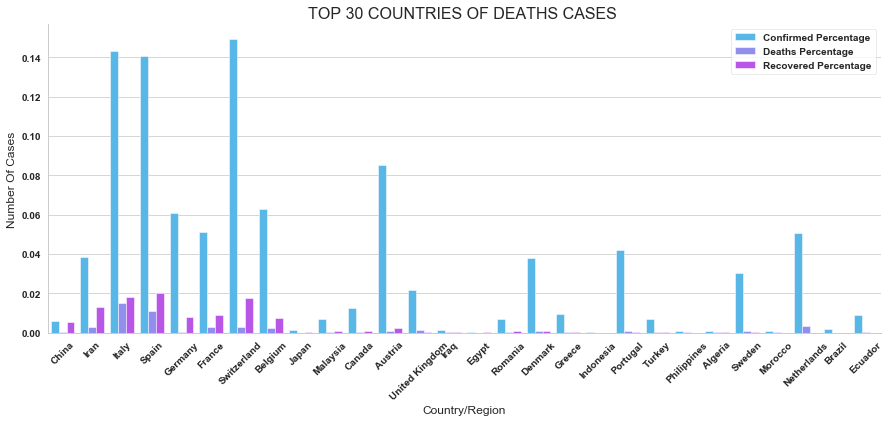

In [95]:
df9 = df7[df7['Country/Region'].isin(top_deaths_list) ]
df9.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df9, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='cool', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF DEATHS CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [96]:
# df8_population = df_2020[df_2020['Location'].isin(top_confirmed_list)]
# df8_population.head()

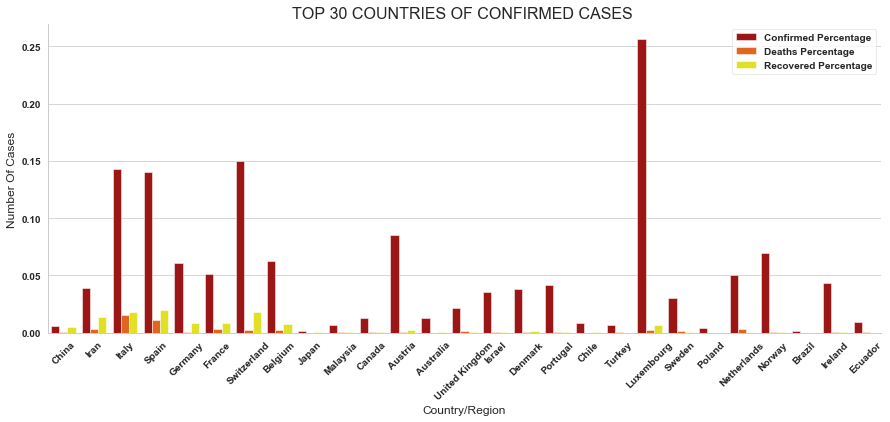

In [97]:
sns.set_style('whitegrid')
g = sns.catplot(data=df8, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='hot', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF CONFIRMED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [ ]:
# df10_population = df_2020[df_2020['Location'].isin(top_recovered_list)]
# df10_population.head()

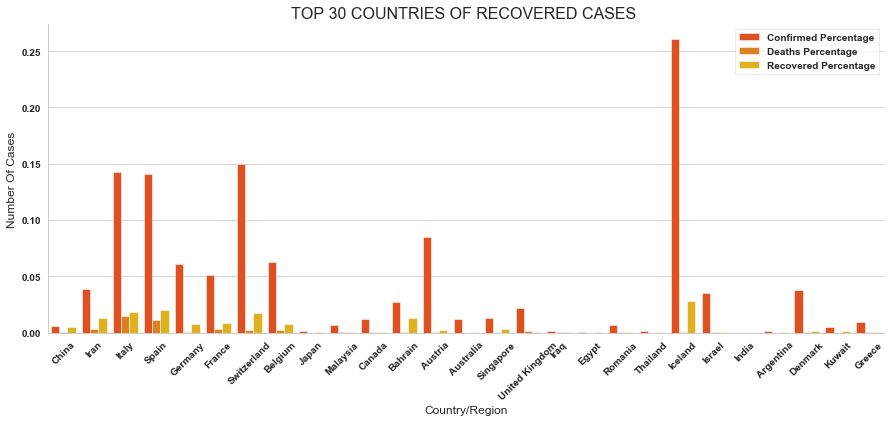

In [98]:
df10 = df7[df7['Country/Region'].isin(top_recovered_list) ]
df10.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df10, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='autumn', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF RECOVERED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [ ]:
# top30_recovered.reset_index(inplace = True)
# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_recovered', data=top30_recovered,
#                 kind='bar', palette='autumn', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

### STEP 5: RESHAPE FROM WIDE TO LONG FORMAT

In [99]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['Country/Region'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [100]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for country in df['Country/Region']:
        melted = melt_data(df.loc[df['Country/Region'] == country])
        row = df.loc[df['Country/Region'] == country].iloc[:,:1]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [101]:
sorted_df_confirmed.reset_index(inplace=True)

In [102]:
sorted_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        1        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       4       4   
1       0       0       0       0       0       0       0       0       2   
2       1       3       5      12      12      17      17      19      20   
3       0       1       1       1       1       1       1       1       1   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        5        7        7        7       11       16       21       22   
1       10       12       23       33       38       42       51       55   
2       20       20       24       26       37       48       54       60   
3        1        1        1        1        1        1        2       39   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0       22       22       24       24       40       40       74       84   
1       59       64       70       76       89      104      123      146   
2       74       87       90      139      201      230      264      302   
3       39       53       75       88      113      133      164      188   
4        0        0        1        2        2        3        3        3   

   3/26/20  3/27/20  
0       94      110  
1      174      186  
2      367      409  
3      224      267  
4        4        4

In [103]:
df = melt_df(sorted_df_confirmed)

In [104]:
df.head()

Country/Region       time  value
0    Afghanistan 2020-01-22      0
1    Afghanistan 2020-01-23      0
2    Afghanistan 2020-01-24      0
3    Afghanistan 2020-01-25      0
4    Afghanistan 2020-01-26      0

In [105]:
# check any columns has na/nan value, if there is missing data
#### forward fill missing value
#df['time'] = df['time'].ffill()
df.isnull().any()

Country/Region    False
time              False
value             False
dtype: bool

#### Convert to Time Series Data by setting the time column as the index

In [106]:
# make it as time series
df.set_index('time', inplace=True)

In [107]:
# look at the head again
df.head()

Country/Region  value
time                            
2020-01-22    Afghanistan      0
2020-01-23    Afghanistan      0
2020-01-24    Afghanistan      0
2020-01-25    Afghanistan      0
2020-01-26    Afghanistan      0

In [108]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Country/Region    False
value             False
dtype: bool

#### Now we see no more missing value in any column. Change the name of feature. Take a look at the final dataframe before performing EDA

In [109]:
# rename columns
df.rename(columns={'Country/Region': 'Country'}, inplace=True)
df.head()

Country  value
time                          
2020-01-22  Afghanistan      0
2020-01-23  Afghanistan      0
2020-01-24  Afghanistan      0
2020-01-25  Afghanistan      0
2020-01-26  Afghanistan      0

In [110]:
df.tail()

Country  value
time                       
2020-03-23  Zimbabwe      3
2020-03-24  Zimbabwe      3
2020-03-25  Zimbabwe      3
2020-03-26  Zimbabwe      3
2020-03-27  Zimbabwe      5

In [ ]:
df

# Step 2: EDA and Visualization

#### Visualization of data at a glance, just to see the whole picture of corona virus spreading.

In [111]:
# countries affected
countries = df['Country'].unique()
len(countries)

176

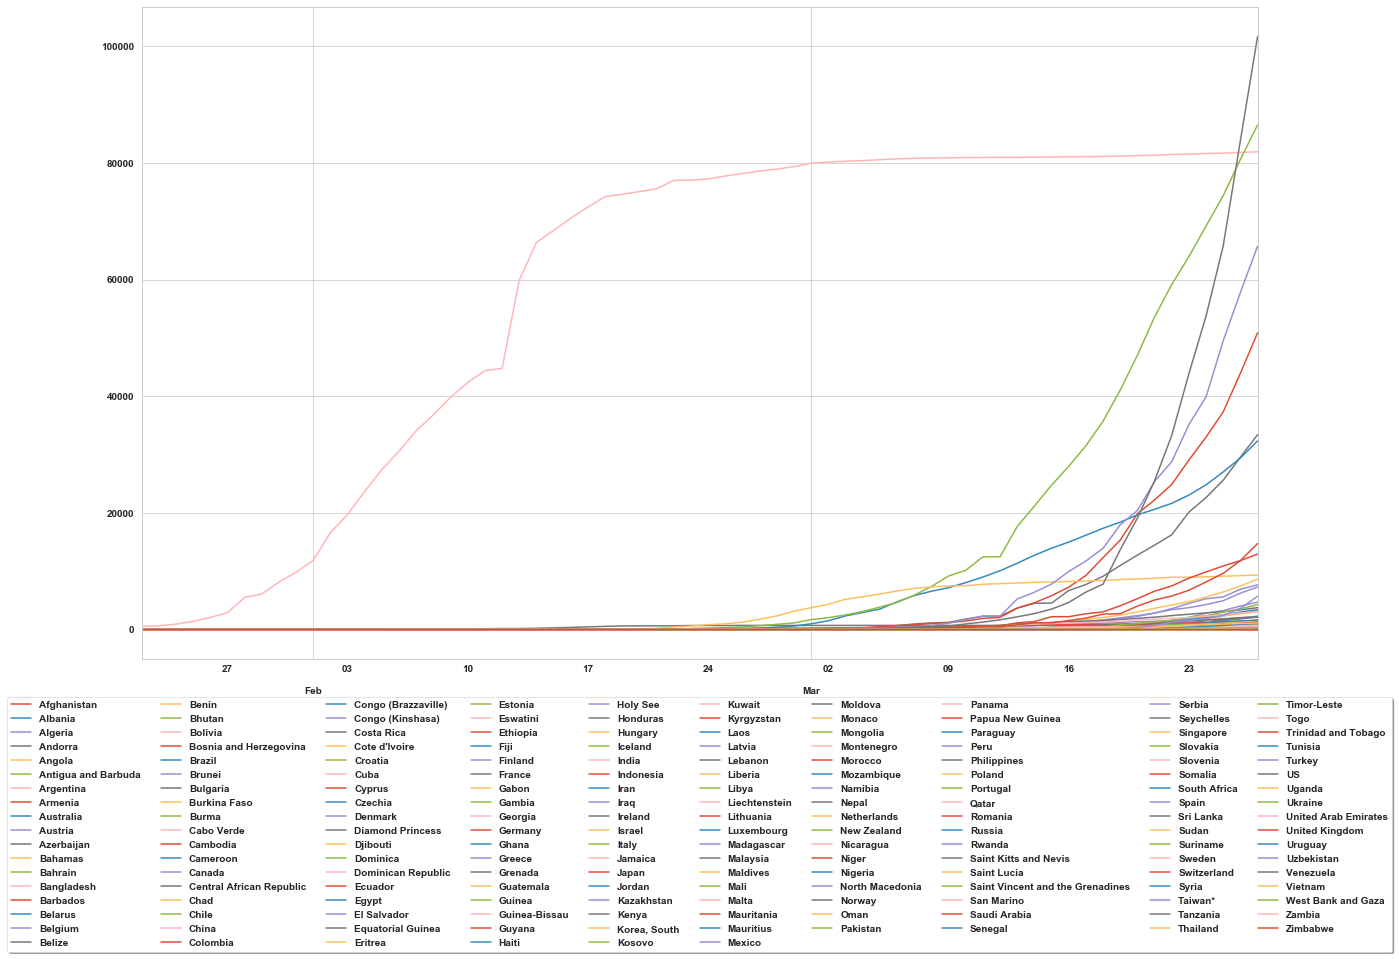

In [112]:
plt.figure(figsize=(20,12))

for c in countries:
    df[df['Country']==c]['value'].plot(label=c)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=10)
plt.show()

### From a quick plot above, we see that the corona virus had started and spreaded widely from China since Jan 22, 2020. There are some countries had started slightly from Feb 20 and the corona virus were actually growing much faster over time. Jan 26, 2020 the spreading speed has increased significantly in some countries such as Singapore, Spain, Iran, Italy . Mar 10, 2020 the corona virus has been spreading out crazily in other countries while there is no new confirmed case. 

#### Run an ETS Decomposition

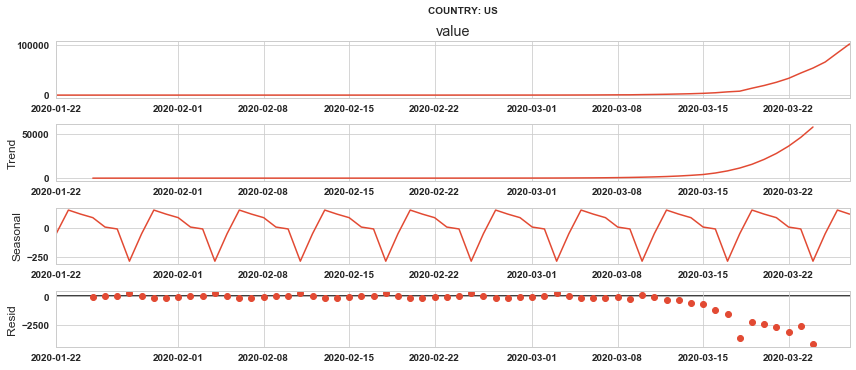

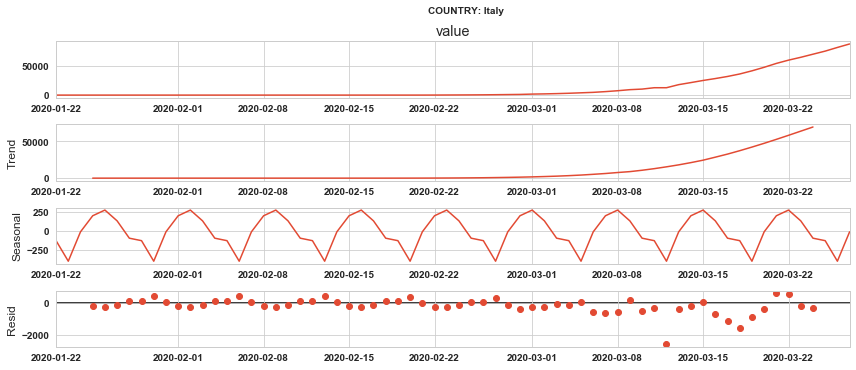

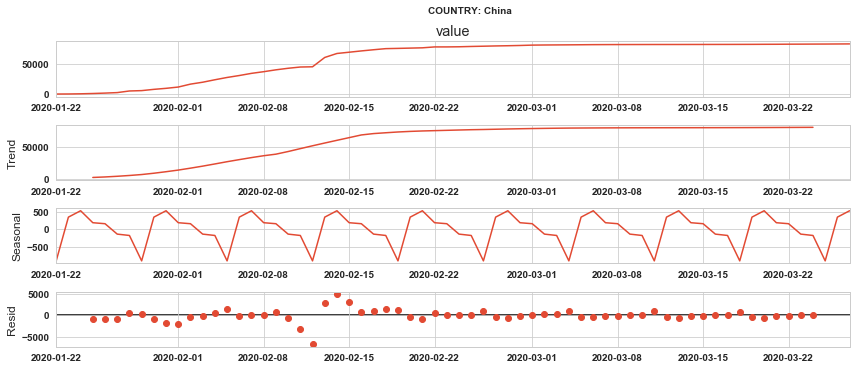

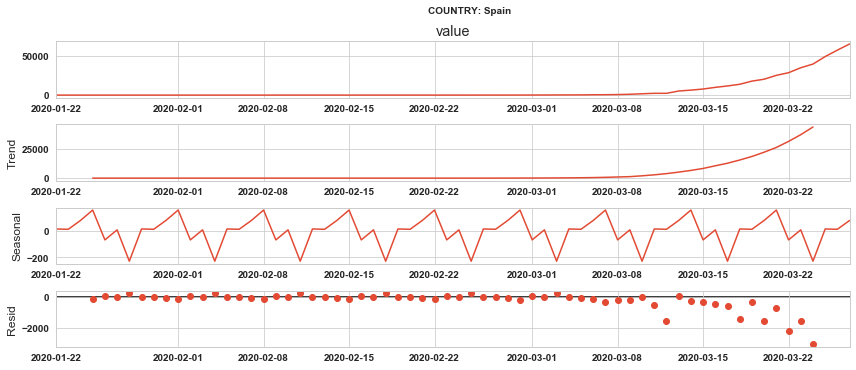

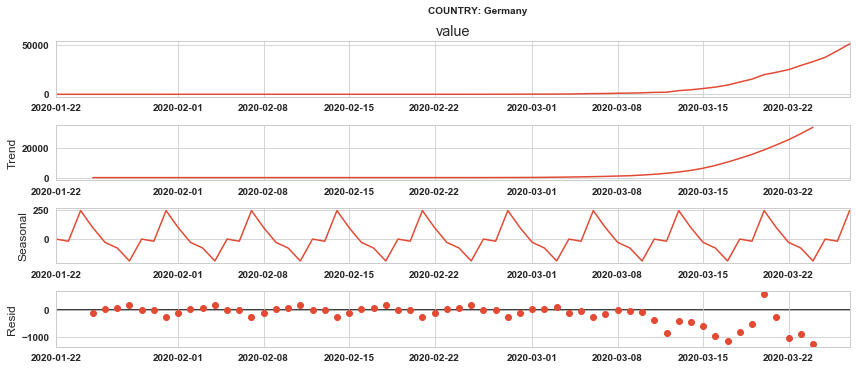

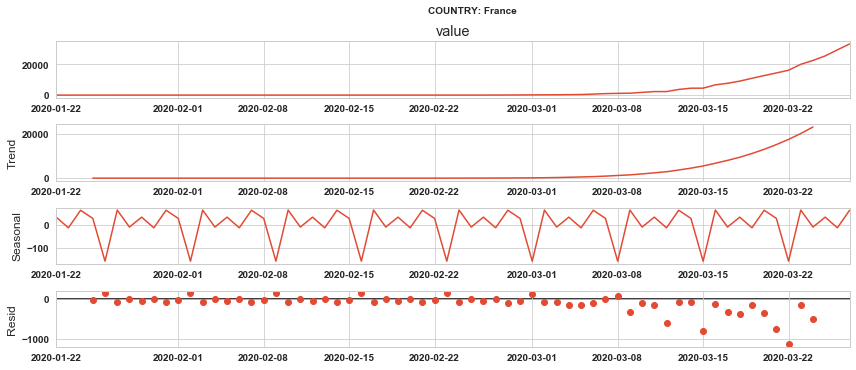

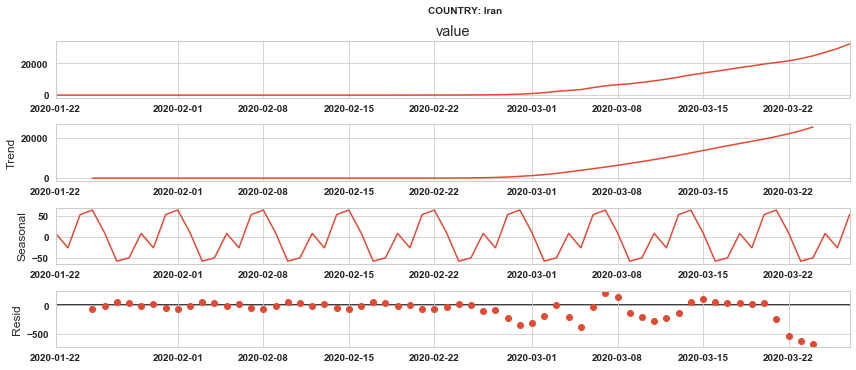

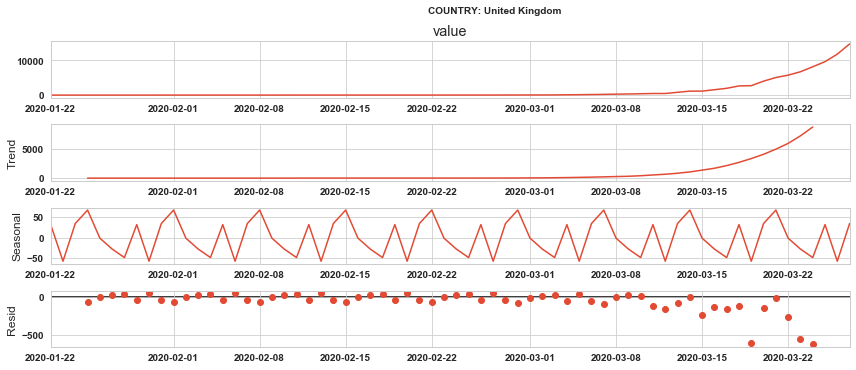

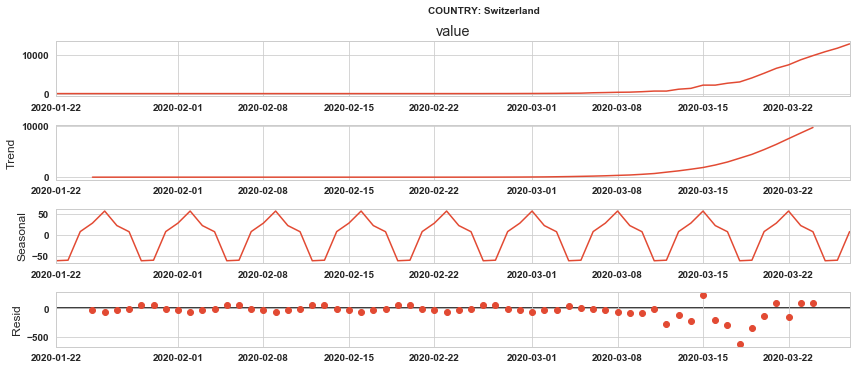

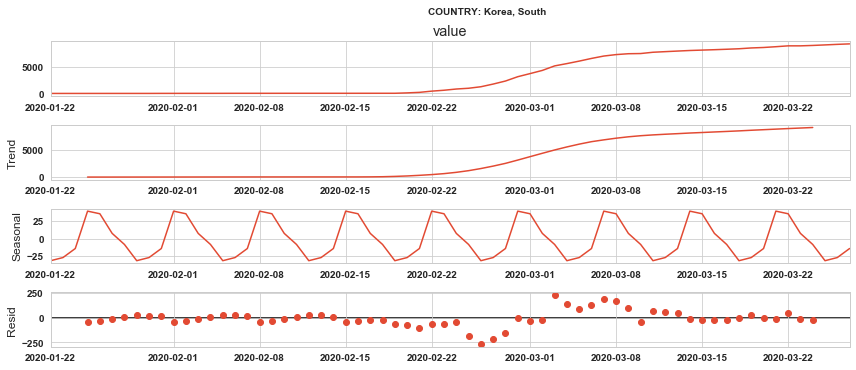

In [113]:
rcParams['figure.figsize'] = 12,5

for country in top_confirmed_list[0:10]:
    results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
    fig = results.plot();
    fig.text(0.5, 1, f'COUNTRY: {country}')

#### Plot ACF and PACF of some zipcodes to check corelation

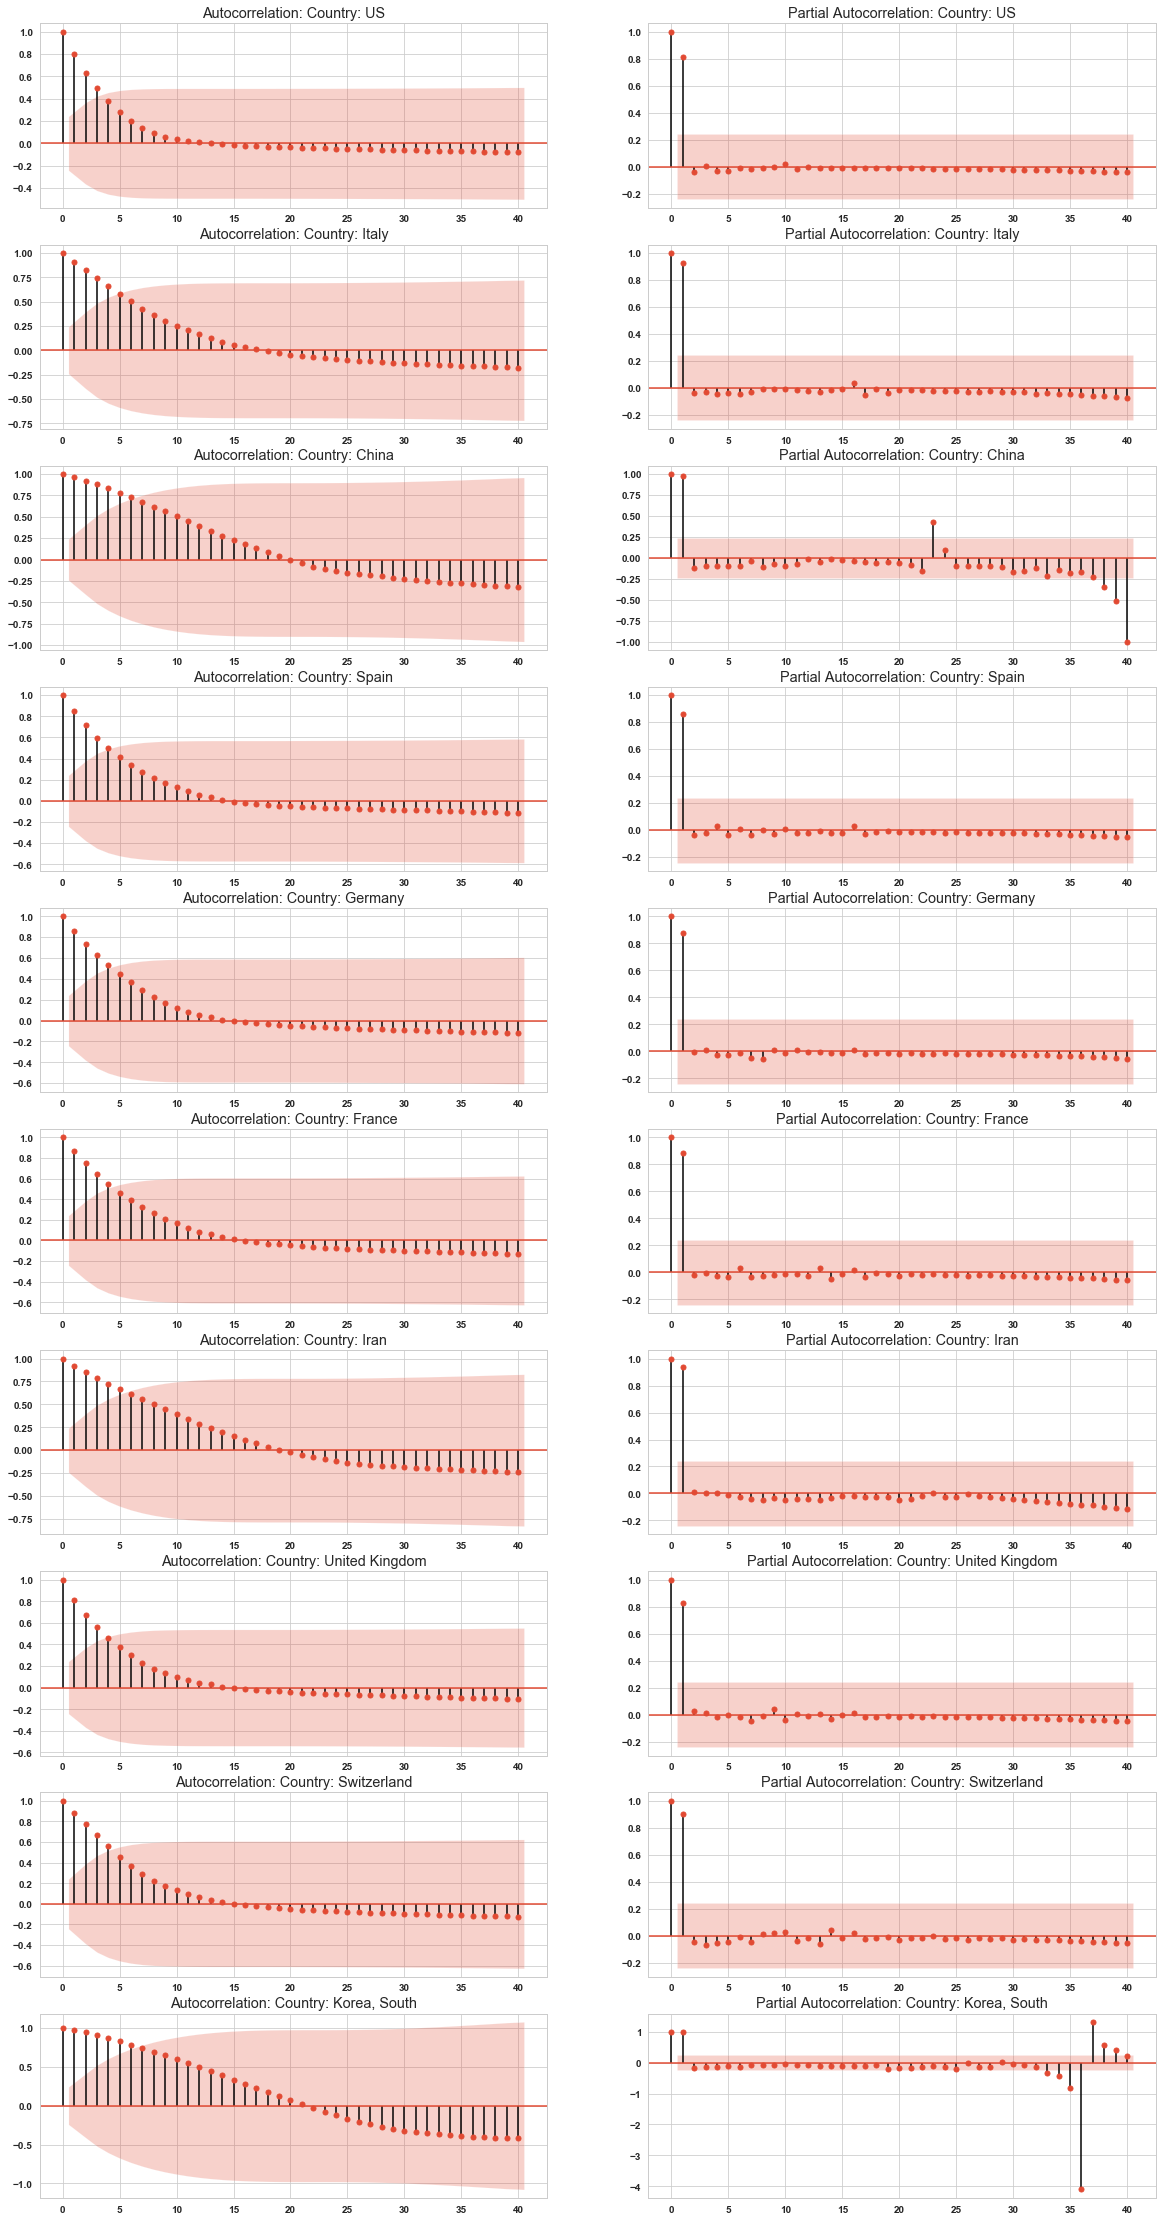

In [114]:
fig = plt.figure(figsize=(20,40))
i = 0
lags=40
for country in top_confirmed_list[0:10]:
    i += 1
    ax = plt.subplot(10,2,i)
    title = f'Autocorrelation: Country: {country}'
    plot_acf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

    i += 1
    ax = plt.subplot(10,2,i)
    title=f'Partial Autocorrelation: Country: {country}'
    plot_pacf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

## Automate the Augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [115]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print("==============================================================")
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print("--------------------------------------------------------------")
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("--------------------------------------------------------------")

In [116]:
# check ADF test for some zipcodes
for country in top_confirmed_list[0:10]:
    adf_test(df.loc[df['Country'] == country].value, title= f'COUNTRY: {country}')

Augmented Dickey-Fuller Test: COUNTRY: US
--------------------------------------------------------------
ADF test statistic       5.406459
p-value                  1.000000
# lags used             11.000000
# observations          54.000000
critical value (1%)     -3.557709
critical value (5%)     -2.916770
critical value (10%)    -2.596222
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
--------------------------------------------------------------
Augmented Dickey-Fuller Test: COUNTRY: Italy
--------------------------------------------------------------
ADF test statistic     -5.857201e+00
p-value                 3.477587e-07
# lags used             9.000000e+00
# observations          5.600000e+01
critical value (1%)    -3.552928e+00
critical value (5%)    -2.914731e+00
critical value (10%)   -2.595137e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is station

### With the Augmented Dickey-Fuller Test results, all data for all zipcodes are non-staytionary. except Italy

# STEP 8: Explore ARIMA Modeling to Find Best Fit Model

### Use grid search to find best fit ARIMA model of one sample country

In [117]:
# One sample test zipcode
country = top_confirmed_list[0]
country

'US'

In [118]:
# test with one zipcode
result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(3, 2, 3)   Log Likelihood                -511.396
Date:                Sat, 28 Mar 2020   AIC                           1038.792
Time:                        10:18:09   BIC                           1056.063
Sample:                             0   HQIC                          1045.596
                                 - 66                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     96.7397    244.861      0.395      0.693    -383.179     576.658
ar.L1          0.5643      0.478      1.182      0.237      -0.372       1.500
ar.L2         -0.4567      0.254     -1.795      0.073      -0.955       0.042
ar.L3          0.8604      0.251      3.424      0.001       0.368       1.353
ma.L1         -0.8246      0.658     -1.254      0.210      -2.113       0.464
ma.L2          0.9676      0.644      1.502      0.133      -0.295       2.230
ma.L3         -0.4785      0.465     -1.029      0.303      -1.390       0.433
sigma2      4.644e+05   8.56e+04      5.425      0.000    2.97e+05    6.32e+05
===================================================================================
Ljung-Box (Q):                       12.31   Jarque-Bera (JB):               821.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.43   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### After having the best-fit model from auto_arima grid search, we double check with visualization of ETS decomposition and ACF and PACF

Text(0.5, 1, 'COUNTRY: US')

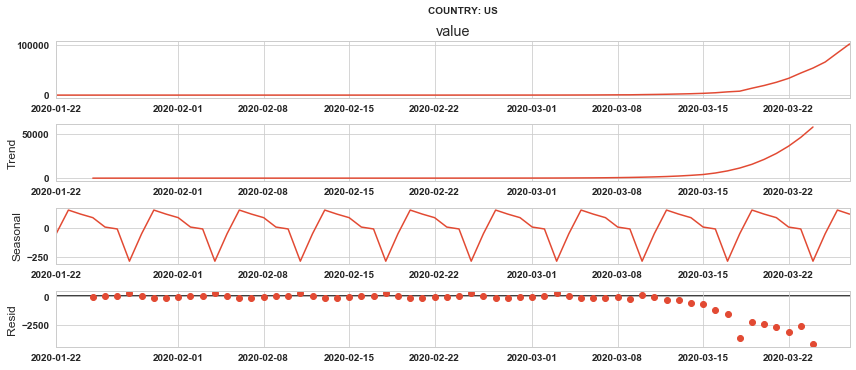

In [119]:
rcParams['figure.figsize'] = 12,5
results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
fig = results.plot();
fig.text(0.5,1,f'COUNTRY: {country}')

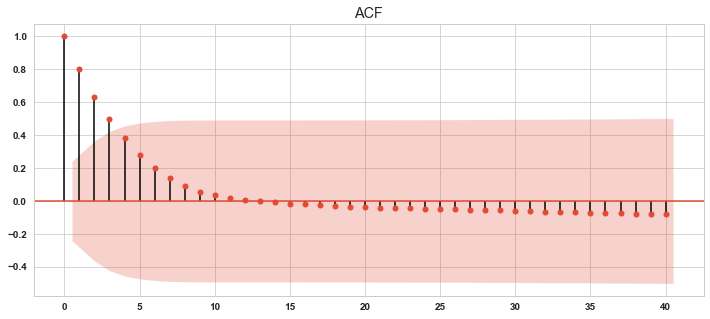

In [120]:
plot_acf(df.loc[df['Country'] == country].value,alpha=0.05,title='ACF',lags=40);

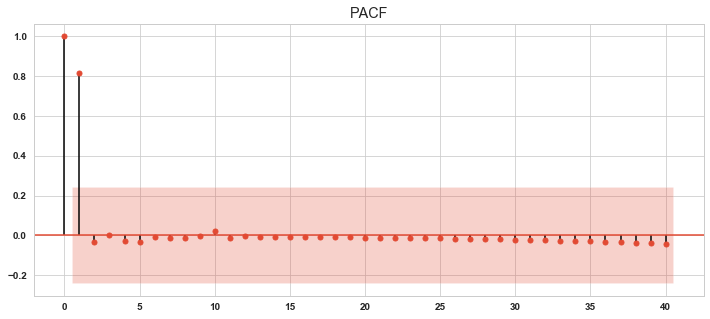

In [121]:
plot_pacf(df.loc[df['Country'] == country].value,alpha=0.05,title='PACF',lags=40);

#### Again, the ACF & PACF plots confirm the zipcode has none seasonality.

### Now, we wrote code to find best-fit models for a list of countries and store the fitted models in to a DataFrame for later dispaly and use
#### For quick testing purpose we only need to test with one country, but we can do for all countries

In [157]:
# find the best fit model for the first test country
models = []
for country in top_confirmed_list[0:1]:
    result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    
    model = {'Country': country, 'model': 'ARIMA', 'order': result.order, 'seasonal_order': None}    
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

zipcode  model      order seasonal_order
0      NaN  ARIMA  (3, 2, 3)           None

#### After having the model, we split data of this country into train/test dataset to evaluate the accurateness of the model

In [124]:
first_country_data = df[df['Country']==country]
first_country_data.head()

Country  value
time                     
2020-01-22      US      1
2020-01-23      US      1
2020-01-24      US      2
2020-01-25      US      2
2020-01-26      US      5

In [125]:
# get tail data of 3 year - test data set
first_country_data.tail(36)

Country   value
time                      
2020-02-21      US      15
2020-02-22      US      15
2020-02-23      US      15
2020-02-24      US      51
2020-02-25      US      51
2020-02-26      US      57
2020-02-27      US      58
2020-02-28      US      60
2020-02-29      US      68
2020-03-01      US      74
2020-03-02      US      98
2020-03-03      US     118
2020-03-04      US     149
2020-03-05      US     217
2020-03-06      US     262
2020-03-07      US     402
2020-03-08      US     518
2020-03-09      US     583
2020-03-10      US     959
2020-03-11      US    1281
2020-03-12      US    1663
2020-03-13      US    2179
2020-03-14      US    2727
2020-03-15      US    3499
2020-03-16      US    4632
2020-03-17      US    6421
2020-03-18      US    7783
2020-03-19      US   13677
2020-03-20      US   19100
2020-03-21      US   25489
2020-03-22      US   33276
2020-03-23      US   43847
2020-03-24      US   53740
2020-03-25      US   65778
2020-03-26      US   83836
2020-03-27      US  101657

In [126]:
# Calculate the split time point for train & test data.
now = datetime.now()
start_date = datetime(2020, 1, 22)
end_date = now
delta = end_date - start_date
train_days = round(delta.days * 0.7)
split_date = start_date + timedelta(days=train_days)

start_date = start_date.date()
end_date = end_date.date()
split_date = split_date.date()

print(start_date)
print(split_date)
print(end_date)

2020-01-22
2020-03-08
2020-03-28


In [127]:
# split train/test data
#train_df = first_country_data.iloc[:train_days] #
train_df = first_country_data.loc[:split_date]
#test_df = first_country_data.iloc[split_date:]  #
test_start_date = split_date + timedelta(days=1) 
test_df = first_country_data.loc[test_start_date:]

In [128]:
train_df.tail()

Country  value
time                     
2020-03-04      US    149
2020-03-05      US    217
2020-03-06      US    262
2020-03-07      US    402
2020-03-08      US    518

In [129]:
test_df.head()

Country  value
time                     
2020-03-09      US    583
2020-03-10      US    959
2020-03-11      US   1281
2020-03-12      US   1663
2020-03-13      US   2179

In [130]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2020-01-22 to 2020-03-08
Data columns (total 2 columns):
Country    47 non-null object
value      47 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [131]:
test_df

Country   value
time                      
2020-03-09      US     583
2020-03-10      US     959
2020-03-11      US    1281
2020-03-12      US    1663
2020-03-13      US    2179
2020-03-14      US    2727
2020-03-15      US    3499
2020-03-16      US    4632
2020-03-17      US    6421
2020-03-18      US    7783
2020-03-19      US   13677
2020-03-20      US   19100
2020-03-21      US   25489
2020-03-22      US   33276
2020-03-23      US   43847
2020-03-24      US   53740
2020-03-25      US   65778
2020-03-26      US   83836
2020-03-27      US  101657

In [132]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2020-03-09 to 2020-03-27
Data columns (total 2 columns):
Country    19 non-null object
value      19 non-null int64
dtypes: int64(1), object(1)
memory usage: 456.0+ bytes


In [153]:
# fit the best model with full historical data for one test zipcode
arima_model = sm.tsa.statespace.SARIMAX(train_df['value'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

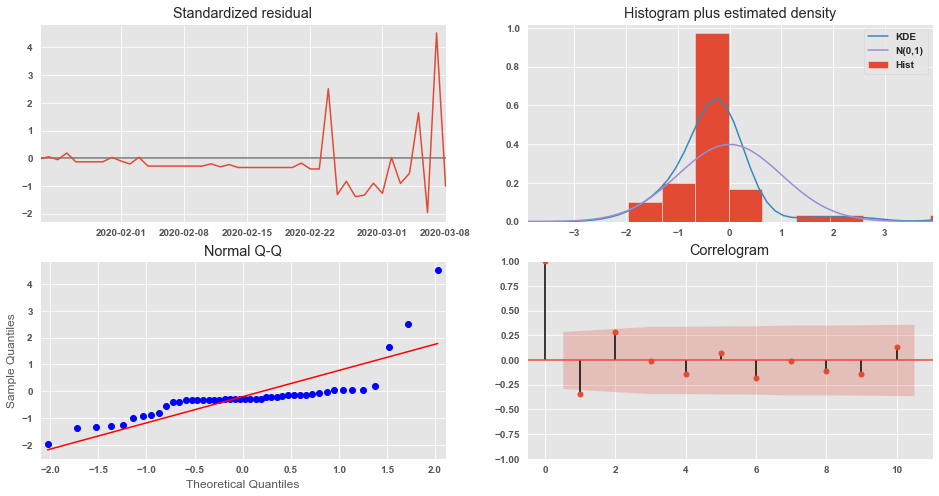

In [154]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Evaluate the prediction and the test data

In [155]:
# forecast the test data
forecast_values = fitted_model.predict(start=test_start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

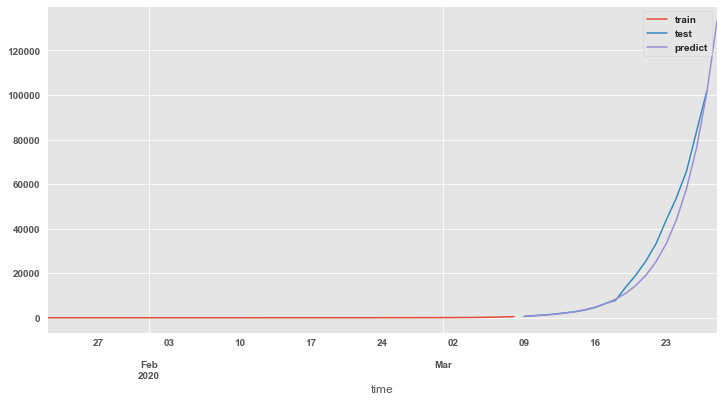

In [156]:
# plot historical and forecasted data
train_df['train'] = train_df['value']
train_df['train'].plot(legend=True,figsize=(12,6))
test_df['test'] = test_df['value']
test_df['test'].plot(legend=True)
forecast_values.plot(legend=True);


In [158]:
# find the best fit model for the first test country
models = []
for country in top_confirmed_list[1:2]:
    result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    
    model = {'Country': country, 'model': 'ARIMA', 'order': result.order, 'seasonal_order': None} 
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

zipcode  model      order seasonal_order
0      NaN  ARIMA  (1, 2, 0)           None

#### After having the model, we split data of this country into train/test dataset to evaluate the accurateness of the model

In [141]:
second_country_data = df[df['Country']==country]
second_country_data.head()

Country  value
time                     
2020-01-22   Italy      0
2020-01-23   Italy      0
2020-01-24   Italy      0
2020-01-25   Italy      0
2020-01-26   Italy      0

In [142]:
# get tail data of 3 year - test data set
second_country_data.tail(36)

Country  value
time                     
2020-02-21   Italy     20
2020-02-22   Italy     62
2020-02-23   Italy    155
2020-02-24   Italy    229
2020-02-25   Italy    322
2020-02-26   Italy    453
2020-02-27   Italy    655
2020-02-28   Italy    888
2020-02-29   Italy   1128
2020-03-01   Italy   1694
2020-03-02   Italy   2036
2020-03-03   Italy   2502
2020-03-04   Italy   3089
2020-03-05   Italy   3858
2020-03-06   Italy   4636
2020-03-07   Italy   5883
2020-03-08   Italy   7375
2020-03-09   Italy   9172
2020-03-10   Italy  10149
2020-03-11   Italy  12462
2020-03-12   Italy  12462
2020-03-13   Italy  17660
2020-03-14   Italy  21157
2020-03-15   Italy  24747
2020-03-16   Italy  27980
2020-03-17   Italy  31506
2020-03-18   Italy  35713
2020-03-19   Italy  41035
2020-03-20   Italy  47021
2020-03-21   Italy  53578
2020-03-22   Italy  59138
2020-03-23   Italy  63927
2020-03-24   Italy  69176
2020-03-25   Italy  74386
2020-03-26   Italy  80589
2020-03-27   Italy  86498

In [143]:
# split train/test data
#train_df = first_country_data.iloc[:train_days] #
train_df2 = first_country_data.loc[:split_date]
#test_df = first_country_data.iloc[split_date:]  #
test_start_date = split_date + timedelta(days=1) 
test_df2 = first_country_data.loc[test_start_date:]

In [144]:
train_df2.tail()

Country  value
time                     
2020-03-04      US    149
2020-03-05      US    217
2020-03-06      US    262
2020-03-07      US    402
2020-03-08      US    518

In [145]:
test_df2.head()

Country  value
time                     
2020-03-09      US    583
2020-03-10      US    959
2020-03-11      US   1281
2020-03-12      US   1663
2020-03-13      US   2179

In [146]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2020-01-22 to 2020-03-08
Data columns (total 2 columns):
Country    47 non-null object
value      47 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [147]:
test_df2

Country   value
time                      
2020-03-09      US     583
2020-03-10      US     959
2020-03-11      US    1281
2020-03-12      US    1663
2020-03-13      US    2179
2020-03-14      US    2727
2020-03-15      US    3499
2020-03-16      US    4632
2020-03-17      US    6421
2020-03-18      US    7783
2020-03-19      US   13677
2020-03-20      US   19100
2020-03-21      US   25489
2020-03-22      US   33276
2020-03-23      US   43847
2020-03-24      US   53740
2020-03-25      US   65778
2020-03-26      US   83836
2020-03-27      US  101657

In [148]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2020-03-09 to 2020-03-27
Data columns (total 2 columns):
Country    19 non-null object
value      19 non-null int64
dtypes: int64(1), object(1)
memory usage: 456.0+ bytes


In [149]:
# fit the best model with full historical data for one test zipcode
arima_model = sm.tsa.statespace.SARIMAX(train_df2['value'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

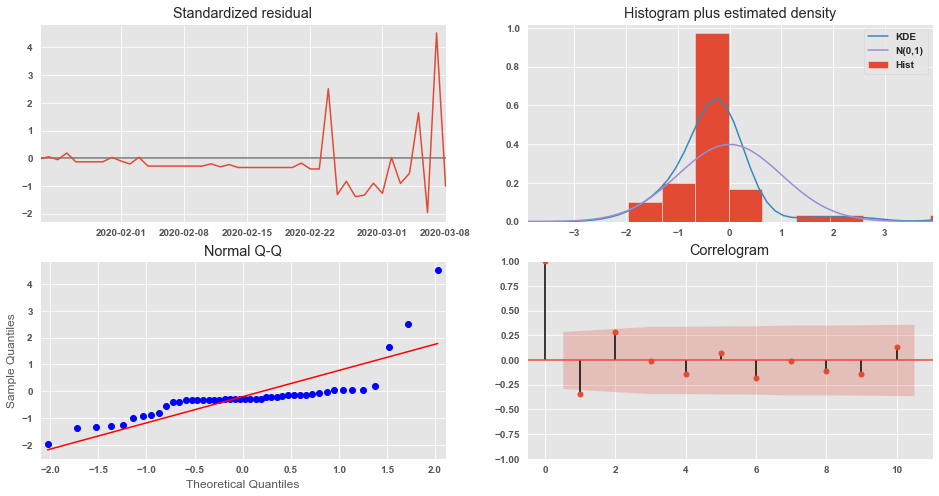

In [150]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Evaluate the prediction and the test data

In [151]:
# forecast the test data
forecast_values = fitted_model.predict(start=test_start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

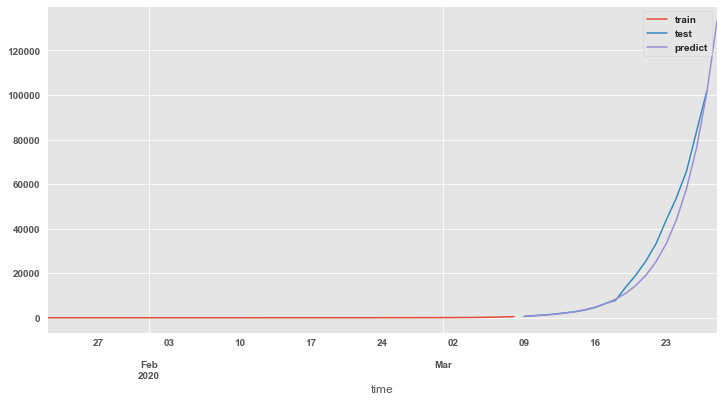

In [152]:
# plot historical and forecasted data
train_df2['train'] = train_df2['value']
train_df2['train'].plot(legend=True,figsize=(12,6))
test_df2['test'] = test_df2['value']
test_df2['test'].plot(legend=True)
forecast_values.plot(legend=True);


### Calculate prediction error

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_df2['value'], forecast_values)
print(f'RMSE: {error}')

In [ ]:
# calculate ROI, Profit
date_range = pd.date_range(start_date, periods=36, freq='MS')
forecast = pd.DataFrame(forecast_values, index=date_range[:])
value = train_df.iloc[-1]['value']
value_after_1_year = round(forecast.iloc[1*12-1]['predict'], 0)
value_after_2_year = round(forecast.iloc[2*12-1]['predict'], 0)
value_after_3_year = round(forecast.iloc[3*12-1]['predict'], 0)
forecast_data = {'Zipcode': zipcode, 'Current Value': value, 
                 'Value After 1 Year': value_after_1_year,
                 'Value After 2 Year': value_after_2_year,
                 'Value After 3 Year': value_after_3_year,
                 'Profit After 1 Year': value_after_1_year - value,
                 'Profit After 2 Year': value_after_2_year - value,
                 'Profit After 3 Year': value_after_3_year - value,
                 'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                 'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                 'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
forecast_data

# Step 5: Modelling and Forecasting The Future for All Zipcodes

#### Now we rewrite all the code for finding best models, fitting models and forecasting into reusable functions to perform forecasting for all the chosen zipcodes

In [ ]:
# function to find best fit model
def find_best_fit_models(dataframe):
    """
    This function use auto_arima to find the best fit model for each zipcode
    provided in the ``zipcodes`` list.
    
    Parameters:
    ------------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    
    Return:
    ------------
    A DataFrame with following data columns: ['zipcode', 'model', 'order', 'seasonal_order']
    """
    # list to store best fit models
    models = []
    
    # zipcodes
    zipcodes = dataframe['zipcode'].unique()
    
    # loop through all zipcodes to find best model for each zipcode
    for zipcode in zipcodes:
        # call auto_arima to find best model
        result = auto_arima(dataframe.loc[dataframe['zipcode'] == zipcode].value, 
                            start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                            trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        # build a model dictionary and put into the returned list
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order, 'seasonal_order': result.seasonal_order}
        models.append(model)

    # convert models list into DataFrame for easy reading
    model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
    
    return model_df

In [ ]:
# function to fit model and forecast future data
def fit_and_forecast(dataframe, model_df):
    """
    This function fit each model in ``model_df`` with the data from ``dataframe``.
    Then, use the fitted model to forecast into the future and calculate the forecasted ROI.
    
    Parameters:
    -----------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    model_df    : the model DataFrame output from function ``find_best_fit_models``
    
    Return:
    -----------
    A DataFrame with forecasted data,
    And a DataFrame with forecasted ROI data
    """
    
    # forecast data to be returned
    ROIs = []
    forecasts = []
    
    # loop through all model in model_df
    for index, model in model_df.iterrows():                
        # fit the best model with full historical data for one test zipcode
        data = dataframe[dataframe['zipcode']==model['zipcode']]
        arima_model = sm.tsa.statespace.SARIMAX(data['value'], order=model['order'], 
                                                seasonal_order=model['seasonal_order'], 
                                                enforce_stationarity=False, enforce_invertibility=False)

        # fit the model and print results
        fitted_model = arima_model.fit()
    
        # last historical data point
        current_data = data.tail(1)
        current_data.reset_index(inplace=True)
        time = current_data.iloc[0]['time']
        zipcode = current_data.iloc[0]['zipcode']
        value = current_data.iloc[0]['value']
        
        # build forecast date range
        date_range = pd.date_range(time, periods=37, freq='MS') # first date is present
        date_range = date_range[1:] # remove the first date
        
        # forecast values of the future
        forecast_values = fitted_model.predict(start=date_range[0],
                  end=date_range[-1], typ='levels').rename('value')
        
        # build forecast dataframe
        forecast_df = pd.DataFrame(forecast_values, index=date_range[:])
        forecast_df['zipcode'] = zipcode
        forecasts.append(forecast_df)
        
        # calculate and build forecasted ROI dataframe
        value_after_1_year = round(forecast_df.iloc[1*12-1]['value'], 0)
        value_after_2_year = round(forecast_df.iloc[2*12-1]['value'], 0)
        value_after_3_year = round(forecast_df.iloc[3*12-1]['value'], 0)
        roi_data = {'Zipcode': zipcode, 
                         'Current Value': value, 
                         'Value After 1 Year':  value_after_1_year,
                         'Value After 2 Year':  value_after_2_year,
                         'Value After 3 Year':  value_after_3_year,
                         'Profit After 1 Year': value_after_1_year - value,
                         'Profit After 2 Year': value_after_2_year - value,
                         'Profit After 3 Year': value_after_3_year - value,
                         'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                         'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                         'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
        
        ROIs.append(roi_data)
    
    # convert models list into DataFrame for easy reading
    roi_df = pd.DataFrame(ROIs, columns=['Zipcode', 'Current Value', 
                           'Value After 1 Year', 'Value After 2 Year', 'Value After 3 Year',
                                'Profit After 1 Year', 'Profit After 2 Year', 'Profit After 3 Year',
                                'ROI After 1 Year', 'ROI After 2 Year', 'ROI After 3 Year'])
    
    # merge all forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    
    return forecast_df, roi_df
    

##### Compare in 3 bar graphs, top30 of current_cases, top30 of current_deaths, top30 of current_recovered.
##### Each graph has 3 color bars show data of 3 current information

### STEP 8: USE ARIMA TO PREDICT TIME SERIES DATA
#### Since we don't have enough data to check if it has seasonal trend  therefore we don't have to check seasonal trend.

### STEP 9: DEEP LEARNING - LONG SHORT TERM MEMORY - LSTM - TO PREDICT

### STEP 10: 

In [310]:
# review the data one more time
df.head()

Country  value
time                          
2020-01-22  Afghanistan      0
2020-01-23  Afghanistan      0
2020-01-24  Afghanistan      0
2020-01-25  Afghanistan      0
2020-01-26  Afghanistan      0

In [311]:
# aggregate data for whole world
df.reset_index(inplace=True)

In [312]:
df.head()

time      Country  value
0 2020-01-22  Afghanistan      0
1 2020-01-23  Afghanistan      0
2 2020-01-24  Afghanistan      0
3 2020-01-25  Afghanistan      0
4 2020-01-26  Afghanistan      0

In [313]:
# sum by country
m = df.groupby(['time'])['value'].sum()

In [314]:
n = pd.DataFrame(m)
n['Country'] = 'World'
n.reset_index(inplace=True)
n.head()

time  value Country
0 2020-01-22   2775   World
1 2020-01-23   3270   World
2 2020-01-24   4705   World
3 2020-01-25   7170   World
4 2020-01-26  10590   World

In [315]:
df = pd.concat([df, n])
df.set_index('time', inplace=True)

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11946 entries, 2020-01-22 to 2020-03-27
Data columns (total 2 columns):
Country    11946 non-null object
value      11946 non-null int64
dtypes: int64(1), object(1)
memory usage: 280.0+ KB


In [317]:
df_world = df[df['Country']=='World']
df_world.head()

Country  value
time                     
2020-01-22   World    555
2020-01-23   World    654
2020-01-24   World    941
2020-01-25   World   1434
2020-01-26   World   2118

In [318]:
# drop non-value column
df_world.drop(columns=['Country'], axis=1, inplace=True)

In [348]:
# train test split
train_size = round(len(df_world) * 0.8)
train_df = df_world[:train_size]
test_df = df_world[train_size:]

In [349]:
train_df.tail()

value
time              
2020-03-23  378235
2020-03-24  418045
2020-03-25  467653
2020-03-26  529591
2020-03-27  593291

In [350]:
print(len(train_df))

264


In [352]:
test_df.head()

value
time             
2020-01-22   2775
2020-01-23   3270
2020-01-24   4705
2020-01-25   7170
2020-01-26  10590

In [347]:
print(len(test_df))

99


In [322]:
# CODE HERE
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

In [323]:
scaled_train

array([[0.00000000e+00],
       [1.67022081e-04],
       [6.51217405e-04],
       [1.48295363e-03],
       [2.63692436e-03],
       [4.00178157e-03],
       [8.47426173e-03],
       [9.46627166e-03],
       [1.29551773e-02],
       [1.58114236e-02],
       [1.93728743e-02],
       [2.73848729e-02],
       [3.26047347e-02],
       [3.93716596e-02],
       [4.56864439e-02],
       [5.10159666e-02],
       [5.70844356e-02],
       [6.16885089e-02],
       [6.68003968e-02],
       [7.12070804e-02],
       [7.46487475e-02],
       [7.53556389e-02],
       [1.00910017e-01],
       [1.11904794e-01],
       [1.15523606e-01],
       [1.19225085e-01],
       [1.22656630e-01],
       [1.25824988e-01],
       [1.26673595e-01],
       [1.27614992e-01],
       [1.28664363e-01],
       [1.31621835e-01],
       [1.32273052e-01],
       [1.33290369e-01],
       [1.34715961e-01],
       [1.36372685e-01],
       [1.38663756e-01],
       [1.40968323e-01],
       [1.44172110e-01],
       [1.48150273e-01],


In [324]:
# use timeseries generator
from keras.preprocessing.sequence import TimeseriesGenerator

In [329]:
# Use seven days data to predict the next day
n_input = 7
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [330]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [331]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [332]:
# fit model
result = model.fit_generator(generator, epochs=30)

Epoch 1/30
224/224 [==============================] - 3s 11ms/step - loss: 0.0298
Epoch 2/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0174
Epoch 3/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0185
Epoch 4/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0147
Epoch 5/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 6/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 7/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0124
Epoch 8/30
224/224 [==============================] - 1s 5ms/step - loss: 0.0101
Epoch 9/30
224/224 [==============================] - 1s 6ms/step - loss: 0.0165
Epoch 10/30
224/224 [==============================] - 1s 6ms/step - loss: 0.0123
Epoch 11/30
224/224 [==============================] - 1s 6ms/step - loss: 0.0119
Epoch 12/30
224/224 [==============================] - 1s 6ms/step - loss: 0.0127
Epoch 13/30
224/224 [===

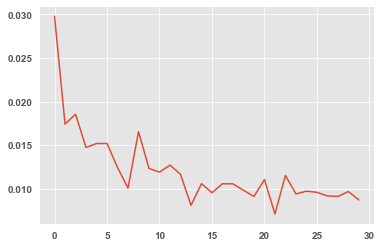

In [333]:
# visualize the loss function per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [334]:
# Evaluate test data
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [335]:
# inverse the scaled values
predictions = scaler.inverse_transform(test_predictions)

In [336]:
# create dataframe from real test data and predicted test data to compare side by side
test_df['prediction'] = predictions

In [342]:
test_df.head()

value     prediction
time                            
2020-02-24  79561   84335.558016
2020-02-25  80406   88160.602668
2020-02-26  81388   92243.025049
2020-02-27  82746   96652.477897
2020-02-28  84112  101461.025209

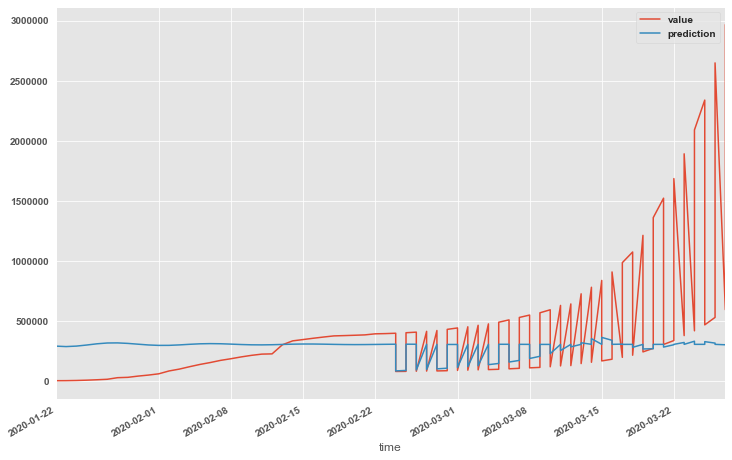

In [338]:
# plot both test data and predict data
test_df.plot(figsize=(12,8))